In [1]:
# Execute only once.

# import os
# # Change working directory = uncertainties folder
# os.chdir(os.path.dirname(os.getcwd()))
# print('Working directory: {}'.format(os.getcwd()))

# import sys
# sys.path.insert(0, os.getcwd())

Working directory: C:\Users\nbros\OneDrive\Documents\These\Code\Github repositories\uncertainties


In [5]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import pickle 
# import utils.metrics as metrics
# import keras

Using TensorFlow backend.


In [6]:
# Load y datasets, one-hot encoding
(_,_), (_,y_mnist) = keras.datasets.mnist.load_data()
(_,_), (_,y_cifar10) = keras.datasets.cifar10.load_data()
(_,_), (_,y_cifar100) = keras.datasets.cifar100.load_data()

y_mnist = keras.utils.to_categorical(y_mnist, 10)
y_cifar10 = keras.utils.to_categorical(y_cifar10, 10)
y_cifar100 = keras.utils.to_categorical(y_cifar100, 100)

In [7]:
# Dictionary for metrics
dic_metrics = {'acc': 'accuracy',
               'bs': 'Brier Score',
               'p_mean': None,
               'p_std': None,
               'neglog': 'negative loglikelihood',
               'ent': 'Entropy of the mean of p',
               'cal': None,
               'q_tab': None,
               'ent_q': 'Entropy of q',
               'mi': 'Mutual information',
               'risk_cov_std': None,
               'risk_cov_softmax': None,
               'risk_cov_q': None
              }

In [11]:
class Reading(object):
  
  def __init__(self, y):
    self.y = y
    dataset = 'mnist-first-10'
    # Paths to folders
    sgd_sgld = 'D:/outputs/last_layer/{}_sgdsgld_lr-0.01_bs-32_s-1000'.format(dataset)
    dropout = 'D:/outputs/last_layer/{}_dropout_ep-100_lr-0.005_bs-32_s-1000_pdrop-0.1'.format(dataset)
    bootstrap = 'D:/outputs/last_layer/{}_bootstrap_ep-10_lr-0.1_bs-32_s-100'.format(dataset)
#     sgd_sgld = 'D:/outputs/full_network/{}_sgdsgld_lr-0.01_bs-32_s-1000'.format(dataset)
#     dropout = 'D:/outputs/full_network/{}_dropout_ep-100_lr-0.005_bs-32_s-1000_pdrop-0.1'.format(dataset)
#     bootstrap = 'D:/outputs/full_network/{}_bootstrap_ep-10_lr-0.1_bs-32_s-100'.format(dataset)
    one_point = 'outputs/last_layer/{}_onepoint'.format(dataset)
    
    # Paths to h5 files
    p_sgd = os.path.join(sgd_sgld, 'p_sgd_in.h5')
    p_sgld = os.path.join(sgd_sgld, 'p_sgld_in.h5')
    p_dropout = os.path.join(dropout, 'p_in.h5')
    p_bootstrap = os.path.join(bootstrap, 'p_in.h5')
    p_onepoint = os.path.join(one_point, 'p_in.h5')
    
    self.simple_sgd = metrics.metrics_from_h5file(y, p_sgd)
    self.simple_sgld = metrics.metrics_from_h5file(y, p_sgld)
    self.dropout = metrics.metrics_from_h5file(y, p_dropout)
    self.bootstrap = metrics.metrics_from_h5file(y, p_bootstrap)
    self.onepoint = metrics.metrics_from_h5file(y, p_onepoint)
    
    
#     with open(p_sgd, 'rb') as f:
#       self.simple_sgd = pickle.load(f)
#     with open(p_sgld, 'rb') as f:
#       self.simple_sgld = pickle.load(f)
#     with open(p_dropout, 'rb') as f:
#       self.dropout = pickle.load(f)
#     with open(p_bootstrap, 'rb') as f:
#       self.bootstrap = pickle.load(f)
#     with open(p_onepoint, 'rb') as f:
#       self.onepoint = pickle.load(f)      

  def plot_scoring_metrics(self, metric, xup=None, ylow=None, yup=None):
    """Plot scoring metrics.
    
    Args:
      metric: string, {'acc', 'bc', 'neglog'}
      xup: upper limit for x axis
      ylow: lower limit for y axis
      yup: upper limit for y axis
    """
    plt.figure(figsize=(15,15))
    plt.plot(self.simple_sgd[metric], label='simple_sgd')
    plt.plot(self.simple_sgld[metric], label='simple_sgld')
    plt.plot(self.dropout[metric], label='dropout')
    plt.plot(self.bootstrap[metric], label='bootstrap')
    plt.xlabel('num_samples')
    plt.ylabel(dic_metrics[metric])
    if xup is not None:
      plt.xlim(0, xup)
      plt.ylim(ylow, yup)
    plt.title(dic_metrics[metric] + ' function of num_samples')
    plt.grid(True)
    plt.legend()
    plt.show()
        
  def plot_information_metrics(self, metric):
    """Plot information metrics.
    
    Args:
      dataset: string, {'mnist', 'notmnist'}
      metric: string, {'ent', 'ent_q', 'mi'}.
    """
    plt.figure(figsize=(15,15))
    n_test = len(self.simple_sgd[metric]) 
    cdf_tab = np.arange(1, n_test+1, dtype=np.float) / n_test
    plt.plot(np.sort(self.simple_sgd[metric]), cdf_tab, label='simple_sgd')
    plt.plot(np.sort(self.simple_sgld[metric]), cdf_tab, label='simple_sgld')
    plt.plot(np.sort(self.dropout[metric]), cdf_tab, label='dropout')
    plt.plot(np.sort(self.bootstrap[metric]), cdf_tab, label='bootstrap')
    plt.xlabel(dic_metrics[metric] + ' values')
    plt.ylabel('cdf on the test set')
    plt.title('CDF of the {} for the test dataset'.format(dic_metrics[metric]))   
    plt.grid(True)
    plt.legend()
    plt.show()
    
  def plot_histograms(self, metric):
    """Plot histograms.
    
    Args:
      metric: string, {'p_mean', 'p_std', 'q_tab'}
    """
    if metric == 'p_std':
      n = self.simple_sgd[metric].shape[0]
      h1 = self.simple_sgd[metric][np.arange(n), 
                                         np.argmax(self.simple_sgd['p_mean'], axis=1)]
      h2 = self.simple_sgld[metric][np.arange(n), 
                                          np.argmax(self.simple_sgld['p_mean'], axis=1)]
      h3 = self.dropout[metric][np.arange(n), 
                                      np.argmax(self.dropout['p_mean'], axis=1)]
      h4 = self.bootstrap[metric][np.arange(n), 
                                        np.argmax(self.bootstrap['p_mean'], axis=1)]        
    else:
      h1 = np.max(self.simple_sgd[metric], axis=1)
      h2 = np.max(self.simple_sgld[metric], axis=1)
      h3 = np.max(self.dropout[metric], axis=1)
      h4 = np.max(self.bootstrap[metric], axis=1)   
    
    plt.figure(figsize=(20,20))
    plt.subplot(2,2,1)
    plt.hist(h1, bins=100, density=True)
    plt.xlabel('Histogram of {} on the test dataset'.format(metric))
    plt.title('simple_sgd')
    plt.subplot(2,2,2)
    plt.hist(h2, bins=100) #Ï, density=True)
    plt.xlabel('Histogram of {} on the test dataset'.format(metric))
    plt.title('simple_sgld')
    plt.subplot(2,2,3)
    plt.hist(h3, bins=100, density=True)
    plt.xlabel('Histogram of {} on the test dataset'.format(metric))
    plt.title('dropout')
    plt.subplot(2,2,4)
    plt.hist(h4, bins=100, density=True)
    plt.xlabel('Histogram of {} on the test dataset'.format(metric))
    plt.title('bootstrap')    
    plt.show()
    
  def plot_calibration(self):
    """Plot calibration."""
    plt.figure(figsize=(15,15))
    plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), label='perfect calibration')
    plt.plot(self.simple_sgd['cal']['reliability_diag'][0], 
             self.simple_sgd['cal']['reliability_diag'][1], 
             label='simple_sgd')
    plt.plot(self.simple_sgld['cal']['reliability_diag'][0], 
             self.simple_sgld['cal']['reliability_diag'][1], 
             label='simple_sgld')
    plt.plot(self.dropout['cal']['reliability_diag'][0], 
             self.dropout['cal']['reliability_diag'][1], 
             label='dropout')
    plt.plot(self.bootstrap['cal']['reliability_diag'][0], 
             self.bootstrap['cal']['reliability_diag'][1], 
             label='bootstrap')
    plt.plot(self.onepoint['cal']['reliability_diag'][0], 
             self.onepoint['cal']['reliability_diag'][1], 
             label='onepoint')    
    plt.grid(True)
    plt.xlabel('Mean confidence')
    plt.ylabel('Mean accuracy')
    plt.title('Reliability diagram')
    plt.legend()
    plt.show()
    
  def plot_risk_coverage(self):
    """Plot Risk Coverage curve."""
    plt.figure(figsize=(15,15))
    n = len(self.simple_sgd['risk_cov_std']['risk_cov'])
    x = np.arange(1./n, 1 + 1./n, 1./n)
    plt.plot(x, self.simple_sgd['risk_cov_std']['risk_cov'], label='simple_sgd')
    plt.plot(x, self.simple_sgld['risk_cov_std']['risk_cov'], label='simple_sgld')
    plt.plot(x, self.dropout['risk_cov_std']['risk_cov'], label='dropout')
    plt.plot(x, self.bootstrap['risk_cov_std']['risk_cov'], label='bootstrap')
    plt.grid(True)
    plt.xlabel('Coverage')
    plt.ylabel('Risk')
    plt.title('Risk-Coverage curve using std of p probability as a confidence function')
    plt.legend()
    plt.show()    
    
    plt.figure(figsize=(15,15))
    plt.plot(x, self.simple_sgd['risk_cov_softmax']['risk_cov'], label='simple_sgd')
    plt.plot(x, self.simple_sgld['risk_cov_softmax']['risk_cov'], label='simple_sgld')
    plt.plot(x, self.dropout['risk_cov_softmax']['risk_cov'], label='dropout')
    plt.plot(x, self.bootstrap['risk_cov_softmax']['risk_cov'], label='bootstrap')
    plt.plot(x, self.onepoint['risk_cov_softmax']['risk_cov'], label='onepoint')
    plt.grid(True)
    plt.xlabel('Coverage')
    plt.ylabel('Risk')
    plt.title('Risk-Coverage curve using max of p probability as a confidence function')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(15,15))
    plt.plot(x, self.simple_sgd['risk_cov_q']['risk_cov'], label='simple_sgd')
    plt.plot(x, self.simple_sgld['risk_cov_q']['risk_cov'], label='simple_sgld')
    plt.plot(x, self.dropout['risk_cov_q']['risk_cov'], label='dropout')
    plt.plot(x, self.bootstrap['risk_cov_q']['risk_cov'], label='bootstrap')
    plt.grid(True)
    plt.xlabel('Coverage')
    plt.ylabel('Risk')
    plt.title('Risk-Coverage curve using q as a classifier and entropy of q as confidence function')
    plt.legend()
    plt.show()
    
  def compute_table(self):
    table = np.zeros((5, 8))
    table[:,0] = np.array([self.simple_sgd['acc'][-1], 
                           self.simple_sgld['acc'][-1],
                           self.dropout['acc'][-1],
                           self.bootstrap['acc'][-1],
                           self.onepoint['acc'][-1]
                          ]
                         )
    table[:,1] = np.array([self.simple_sgd['neglog'][-1], 
                           self.simple_sgld['neglog'][-1],
                           self.dropout['neglog'][-1],
                           self.bootstrap['neglog'][-1],
                           self.onepoint['neglog'][-1]
                          ]
                         )
    table[:,2] = np.array([self.simple_sgd['bs'][-1], 
                           self.simple_sgld['bs'][-1],
                           self.dropout['bs'][-1],
                           self.bootstrap['bs'][-1],
                           self.onepoint['bs'][-1]
                          ]
                         )
    table[:,3] = np.array([self.simple_sgd['cal']['ece'], 
                           self.simple_sgld['cal']['ece'],
                           self.dropout['cal']['ece'],
                           self.bootstrap['cal']['ece'],
                           self.onepoint['cal']['ece']
                          ]
                         )
    table[:,4] = np.array([self.simple_sgd['cal']['mce'], 
                           self.simple_sgld['cal']['mce'],
                           self.dropout['cal']['mce'],
                           self.bootstrap['cal']['mce'],
                           self.onepoint['cal']['mce']
                          ]
                         )
    table[:,5] = np.array([self.simple_sgd['risk_cov_std']['aurc'], 
                           self.simple_sgld['risk_cov_std']['aurc'],
                           self.dropout['risk_cov_std']['aurc'],
                           self.bootstrap['risk_cov_std']['aurc'],
                           np.nan
                          ]
                         )
    table[:,6] = np.array([self.simple_sgd['risk_cov_softmax']['aurc'], 
                           self.simple_sgld['risk_cov_softmax']['aurc'],
                           self.dropout['risk_cov_softmax']['aurc'],
                           self.bootstrap['risk_cov_softmax']['aurc'],
                           self.onepoint['risk_cov_softmax']['eaurc']
                          ]
                         )
    table[:,7] = np.array([self.simple_sgd['risk_cov_q']['aurc'], 
                           self.simple_sgld['risk_cov_q']['aurc'],
                           self.dropout['risk_cov_q']['aurc'],
                           self.bootstrap['risk_cov_q']['aurc'],
                           np.nan
                          ]
                         )
    table = pd.DataFrame(table)
    table.rename(columns={0:'accuracy', 1:'neg loglikelihood', 2:'brier score', 
                      3:'expected calibration error', 4:'maximum calibration error',
                      5:'AURC std max p', 6:'AURC max p', 7:'AURC entropy q'},
             index={0:'sgd', 1:'sgld', 2:'dropout', 3:'bootstrap', 4:'onepoint'}, 
             inplace=True)
    self.table = table
    

# Cifar10

In [12]:
dataset = 'mnist-first-10'
npzfile = np.load('saved_models/{}/y.npz'.format(dataset))
y = npzfile['y_test_in']

In [13]:
rm = Reading(y)

----------------
Reading file D:/outputs/last_layer/mnist-first-10_sgdsgld_lr-0.01_bs-32_s-1000\p_sgd_in.h5 divided in 1 chunks.
----------------
----------------
Reading file D:/outputs/last_layer/mnist-first-10_sgdsgld_lr-0.01_bs-32_s-1000\p_sgld_in.h5 divided in 1 chunks.
----------------
----------------
Reading file D:/outputs/last_layer/mnist-first-10_dropout_ep-100_lr-0.005_bs-32_s-1000_pdrop-0.1\p_in.h5 divided in 1 chunks.
----------------
----------------
Reading file D:/outputs/last_layer/mnist-first-10_bootstrap_ep-10_lr-0.1_bs-32_s-100\p_in.h5 divided in 1 chunks.
----------------
----------------
Reading file outputs/last_layer/mnist-first-10_onepoint\p_in.h5 divided in 1 chunks.
----------------


In [12]:
# Temporary
# for metric in ['acc', 'bs', 'neglog']:
#   rm.simple_sgd[metric] = np.mean(rm.simple_sgd[metric], axis=0)
#   rm.simple_sgld[metric] = np.mean(rm.simple_sgld[metric], axis=0)
#   rm.dropout[metric] = np.mean(rm.dropout[metric], axis=0)
#   rm.bootstrap[metric] = np.mean(rm.bootstrap[metric], axis=0)
#   rm.onepoint[metric] = np.mean(rm.onepoint[metric], axis=0)

In [15]:
# rm.simple_sgd['acc'].shape
rm.bootstrap = rm.bootstraps

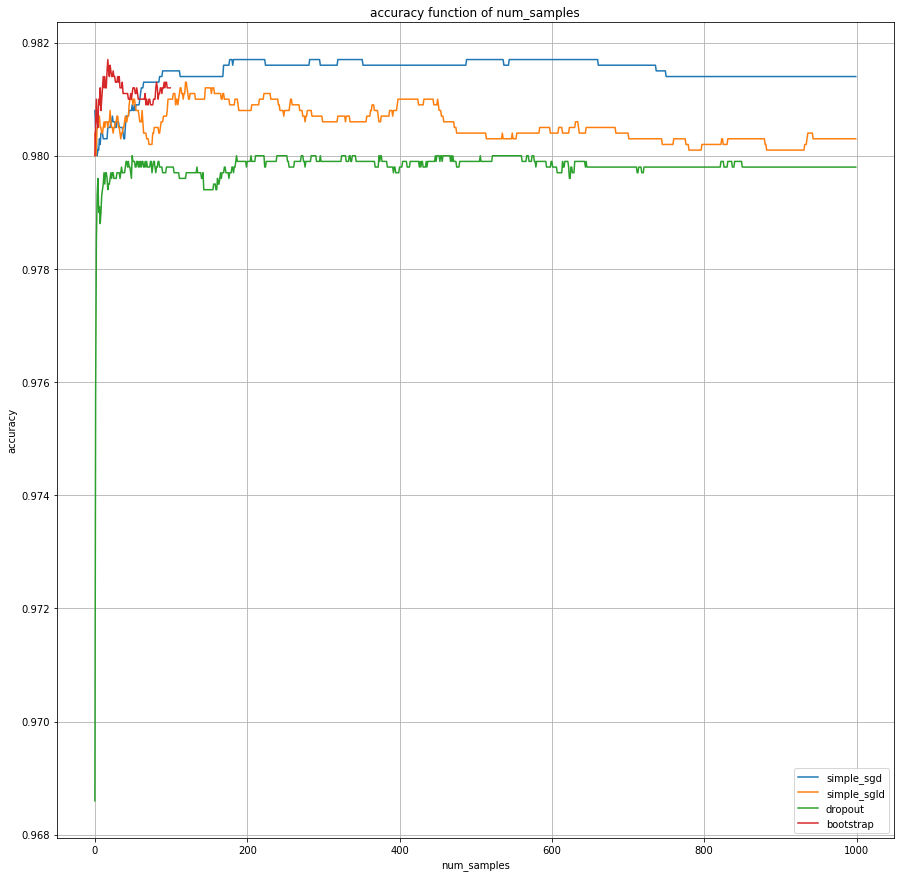

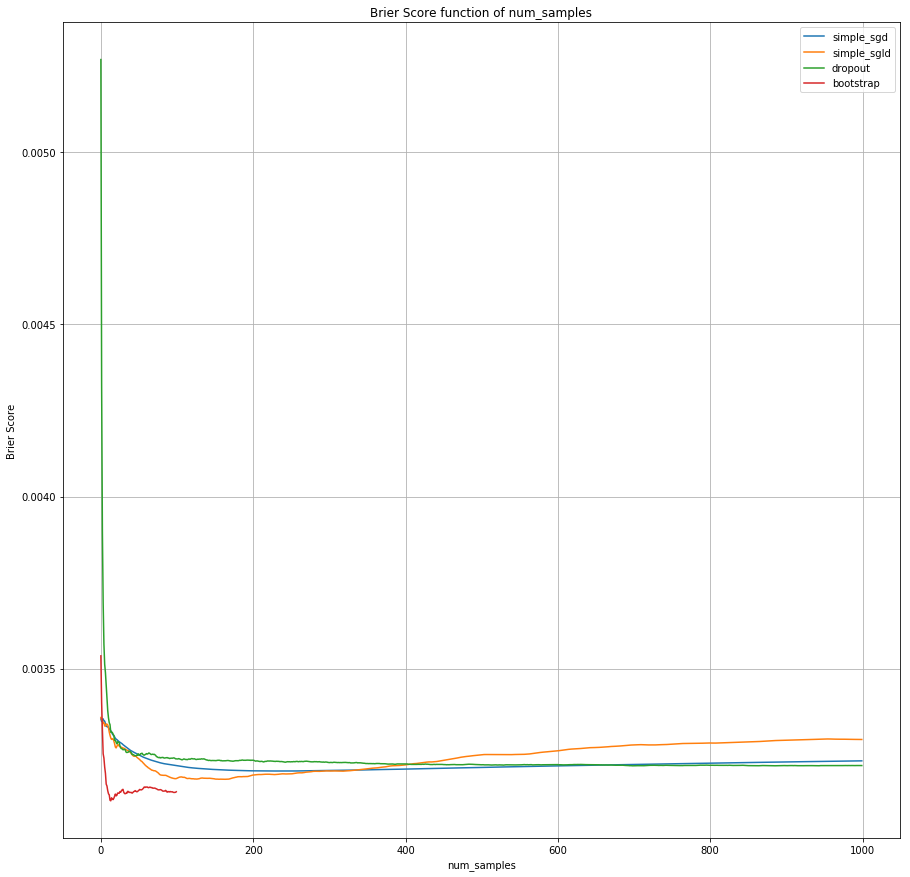

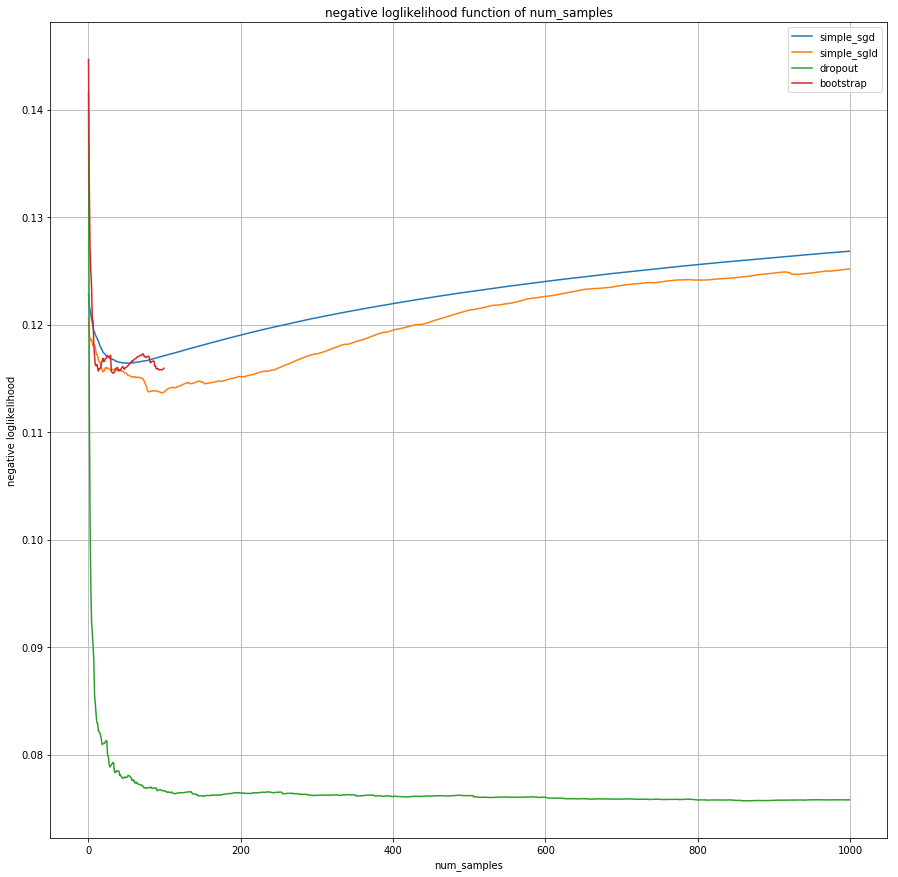

In [16]:
for metric in ['acc', 'bs', 'neglog']:
  rm.plot_scoring_metrics(metric)

In [15]:
rm.simple_sgd['q_tab'].shape

(10000, 10)

In [16]:
rm.simple_sgd['ent'] = rm.simple_sgd['ent'].flatten()
rm.simple_sgld['ent'] = rm.simple_sgld['ent'].flatten()
rm.dropout['ent'] = rm.dropout['ent'].flatten()
rm.bootstrap['ent'] = rm.bootstrap['ent'].flatten()

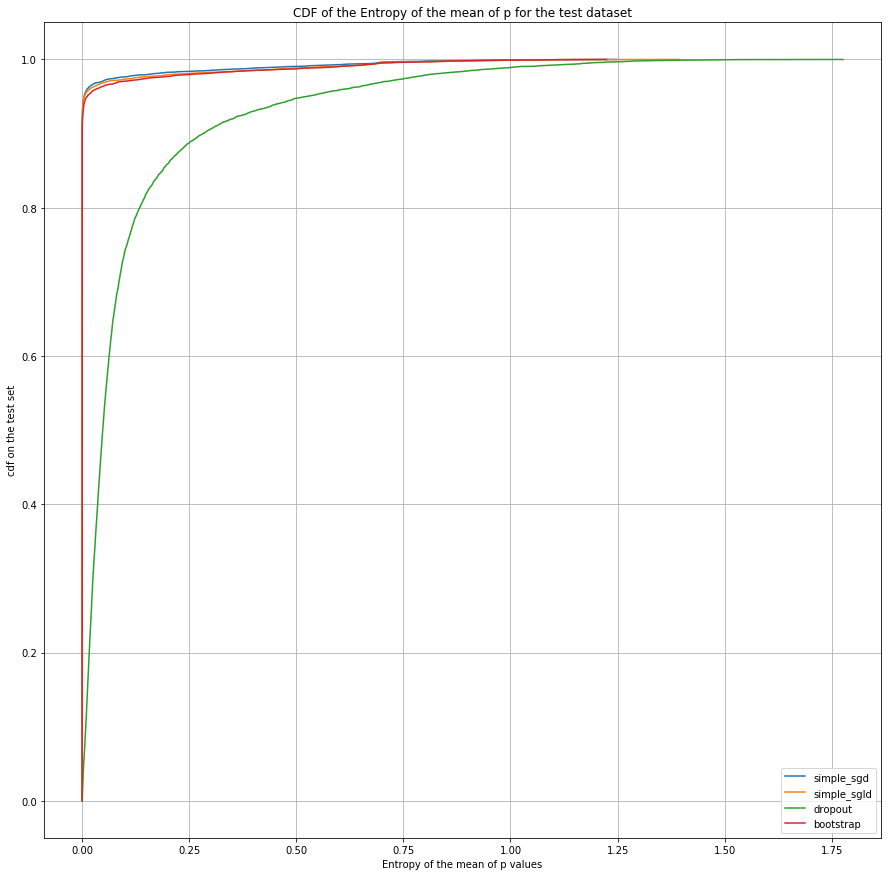

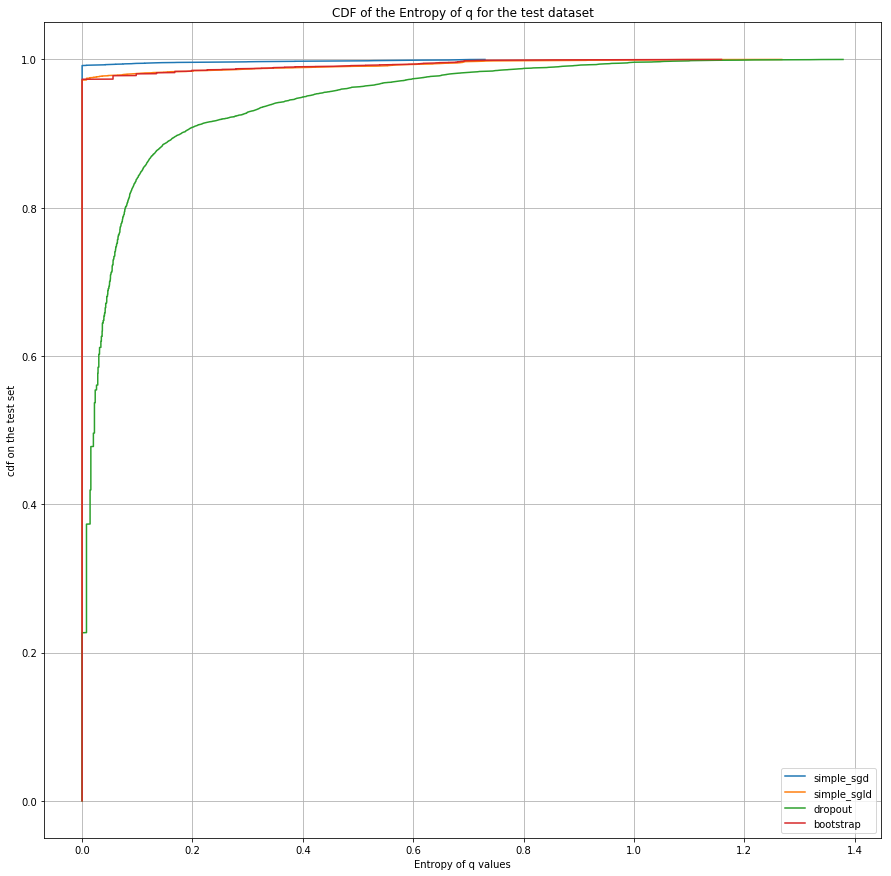

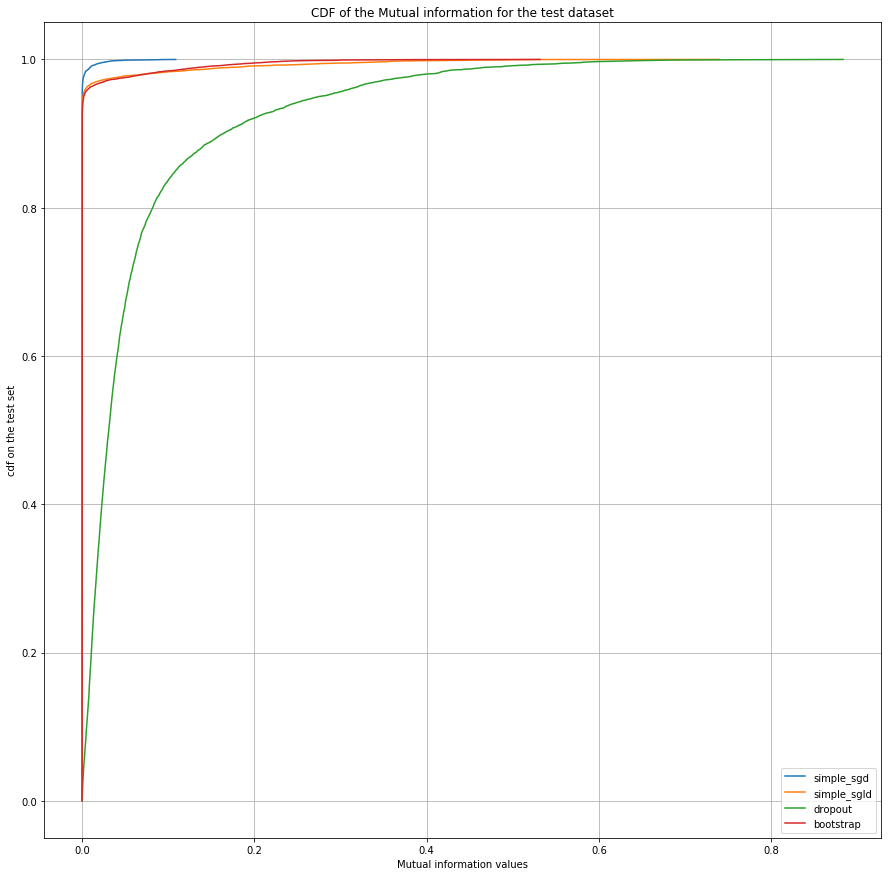

In [17]:
for metric in ['ent', 'ent_q', 'mi']:
  rm.plot_information_metrics(metric)

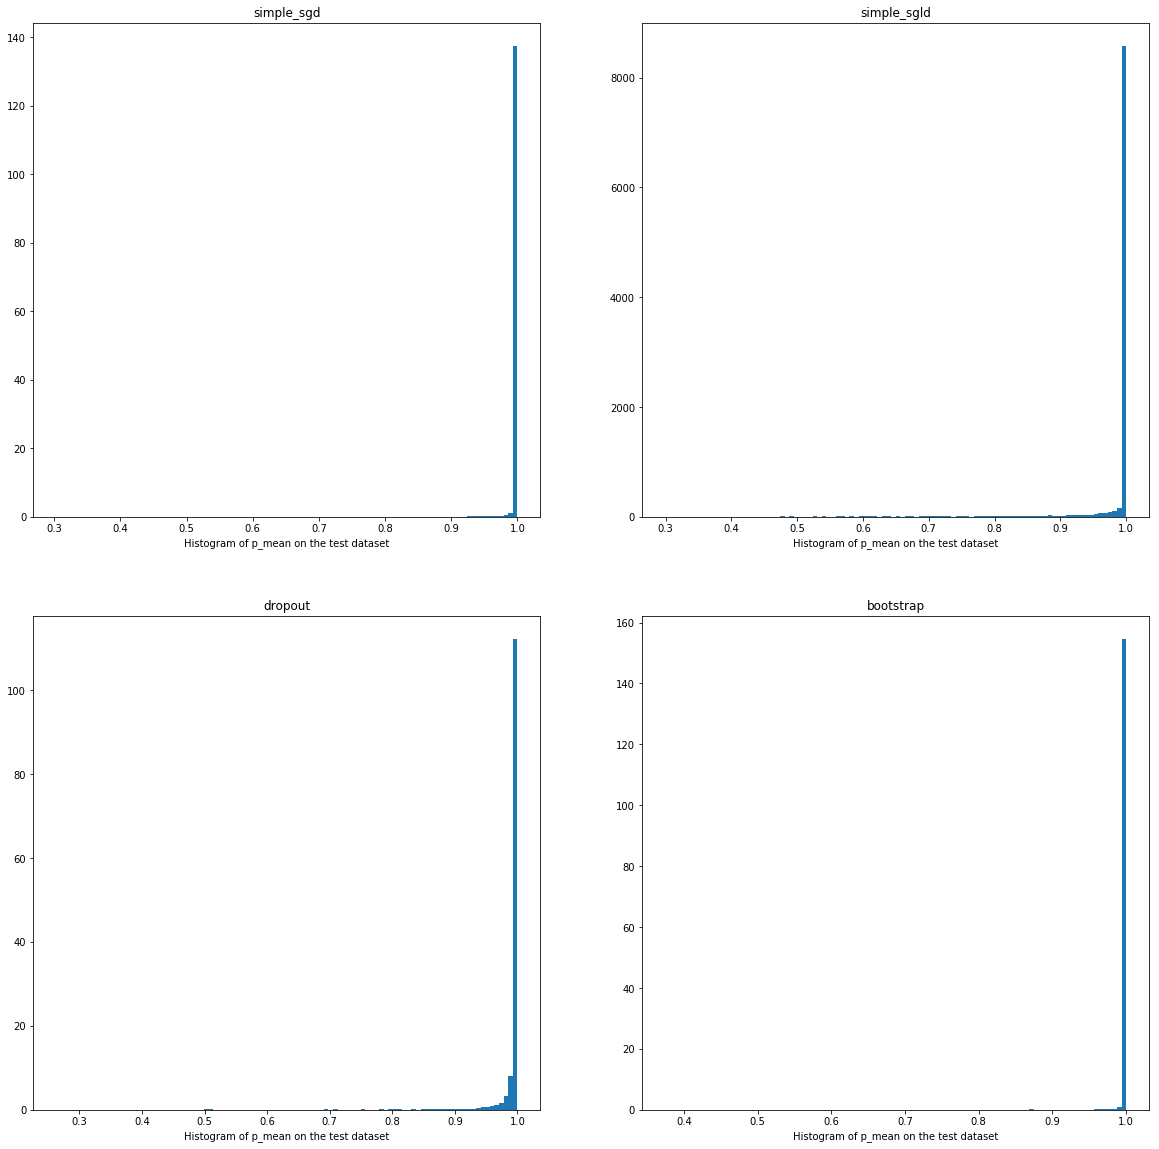

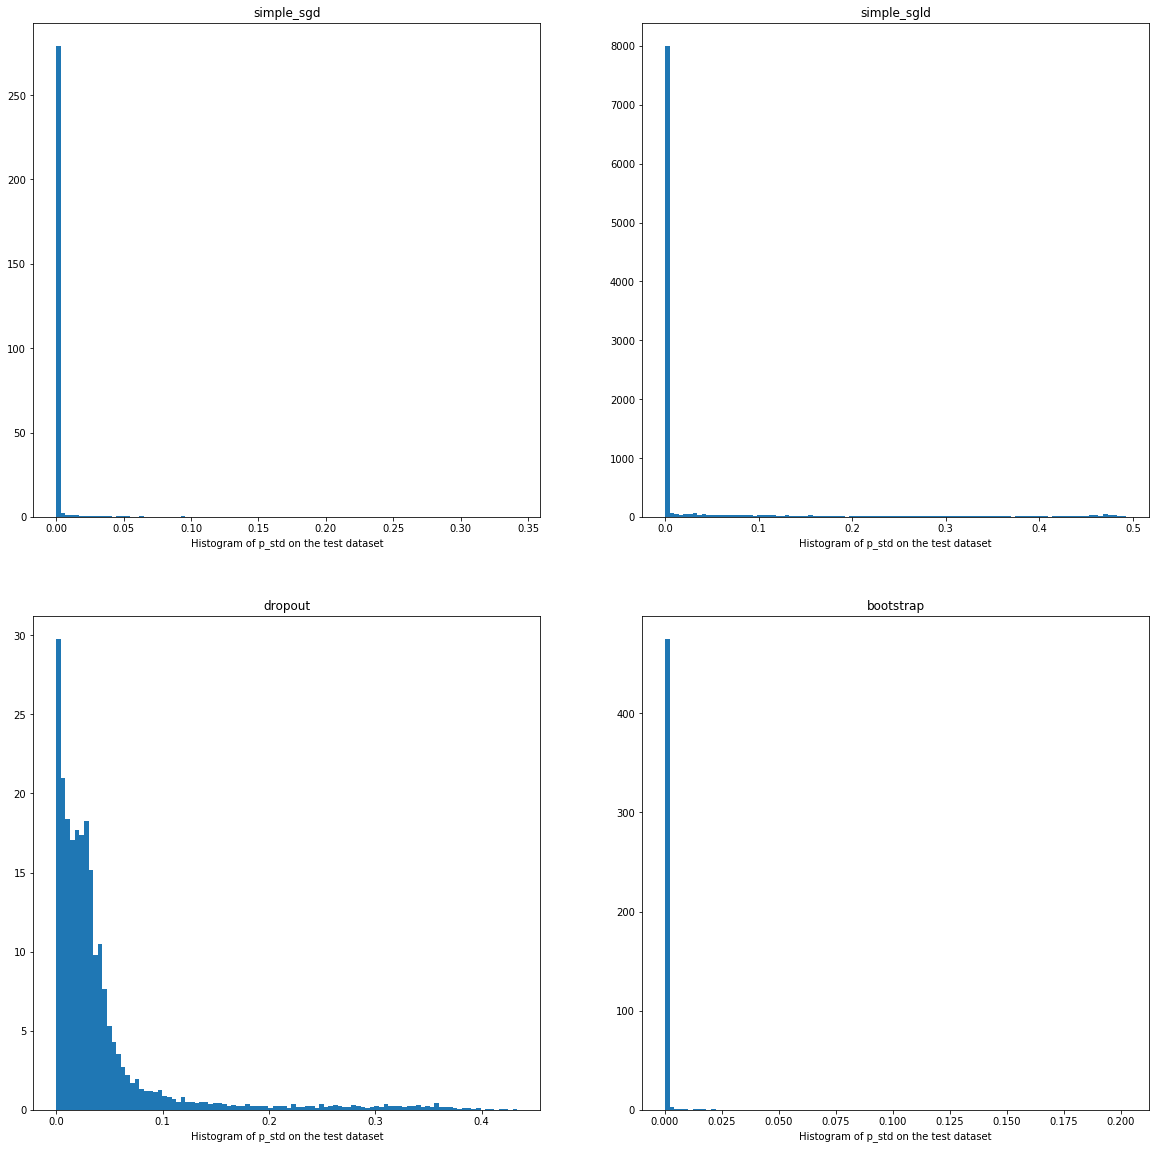

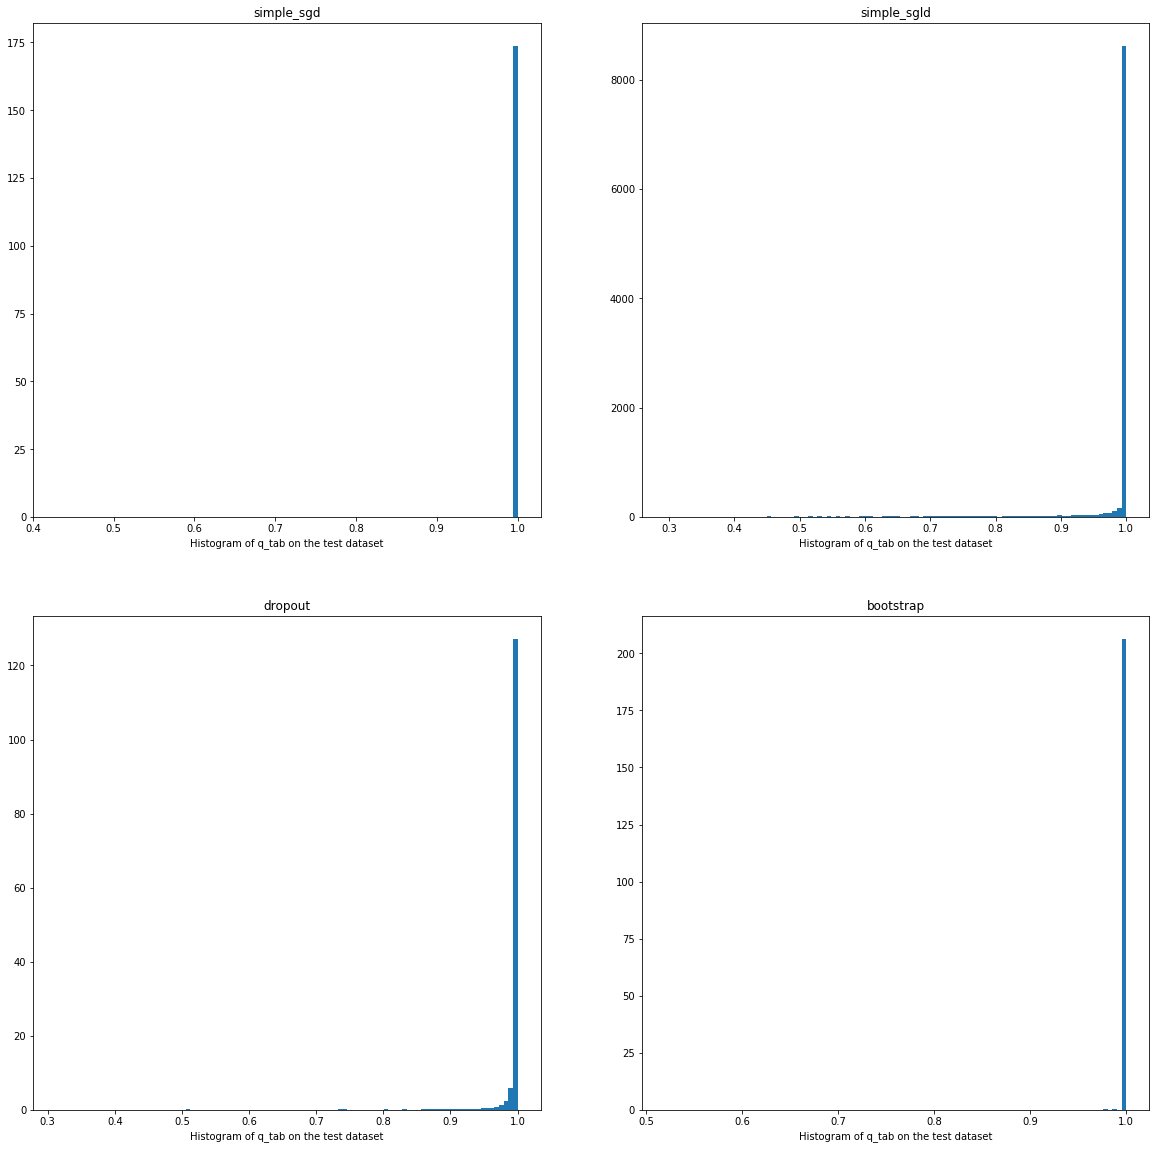

In [18]:
for metric in ['p_mean', 'p_std', 'q_tab']:
  rm.plot_histograms(metric)

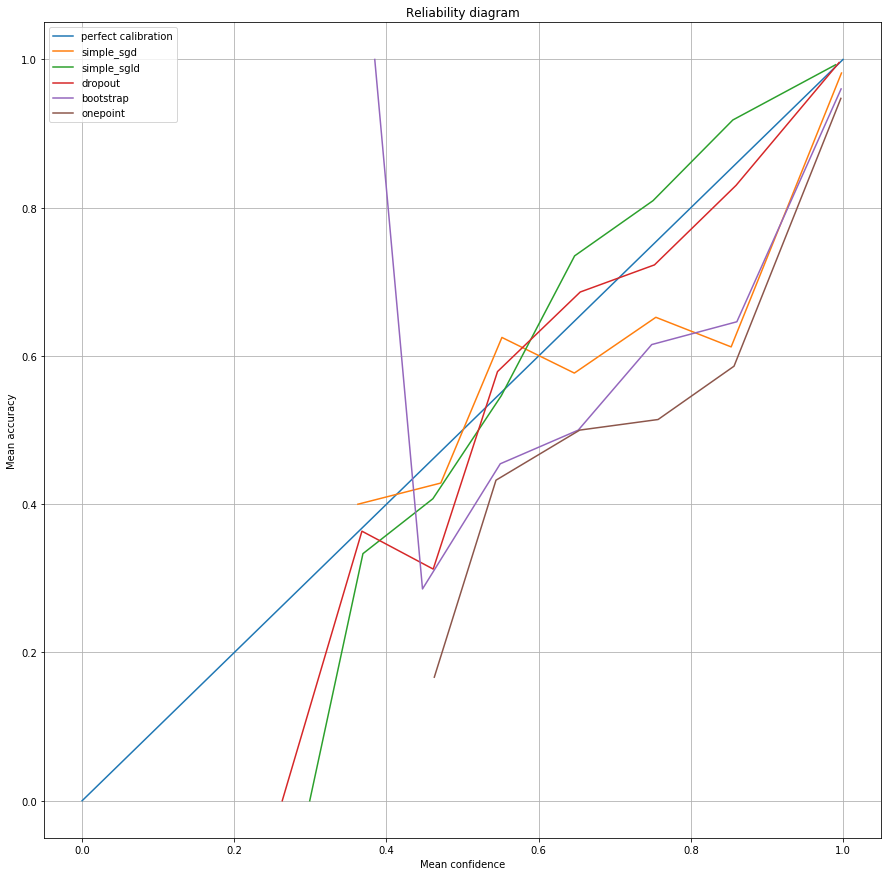

In [19]:
rm.plot_calibration()

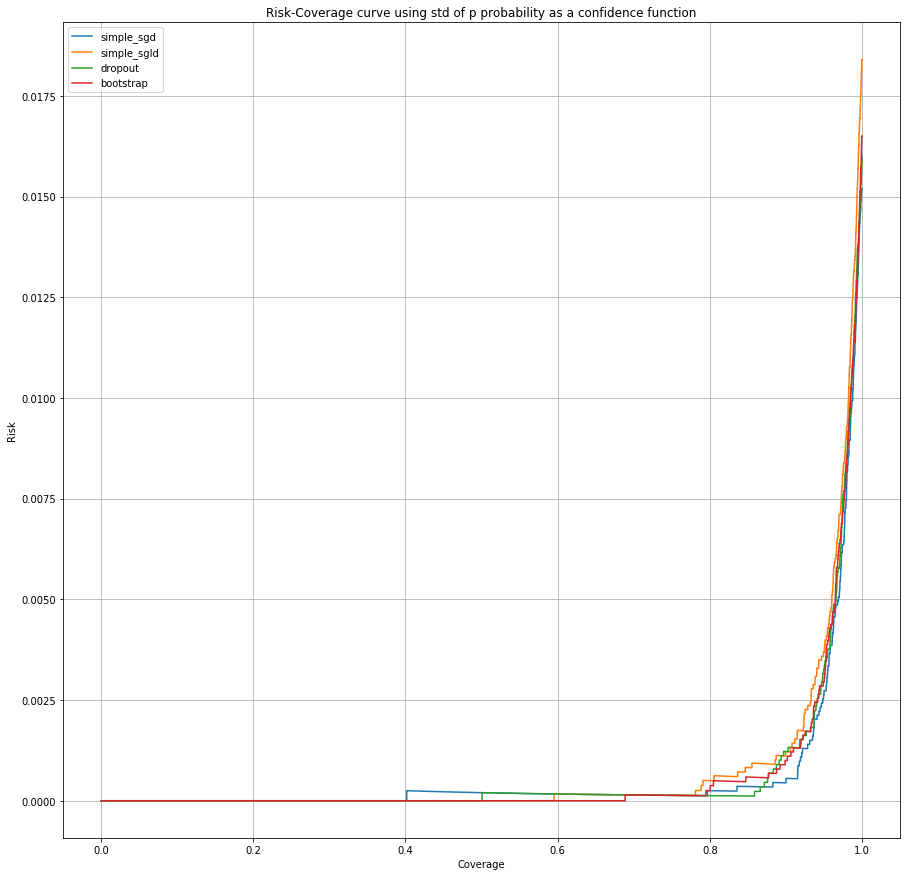

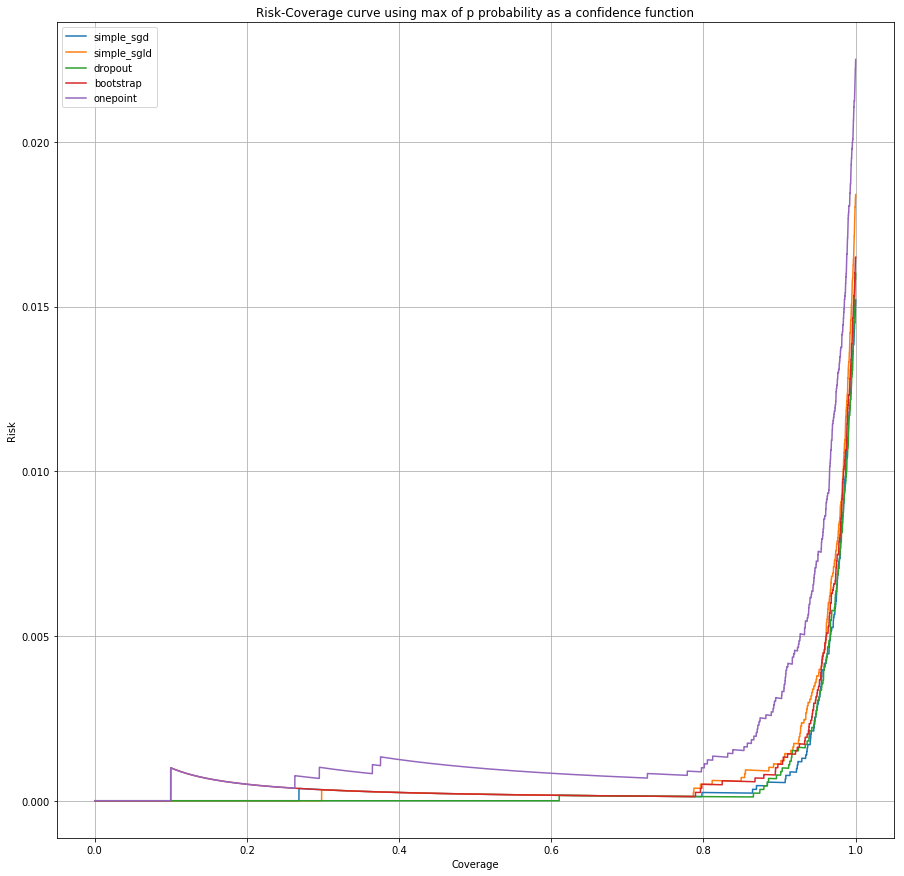

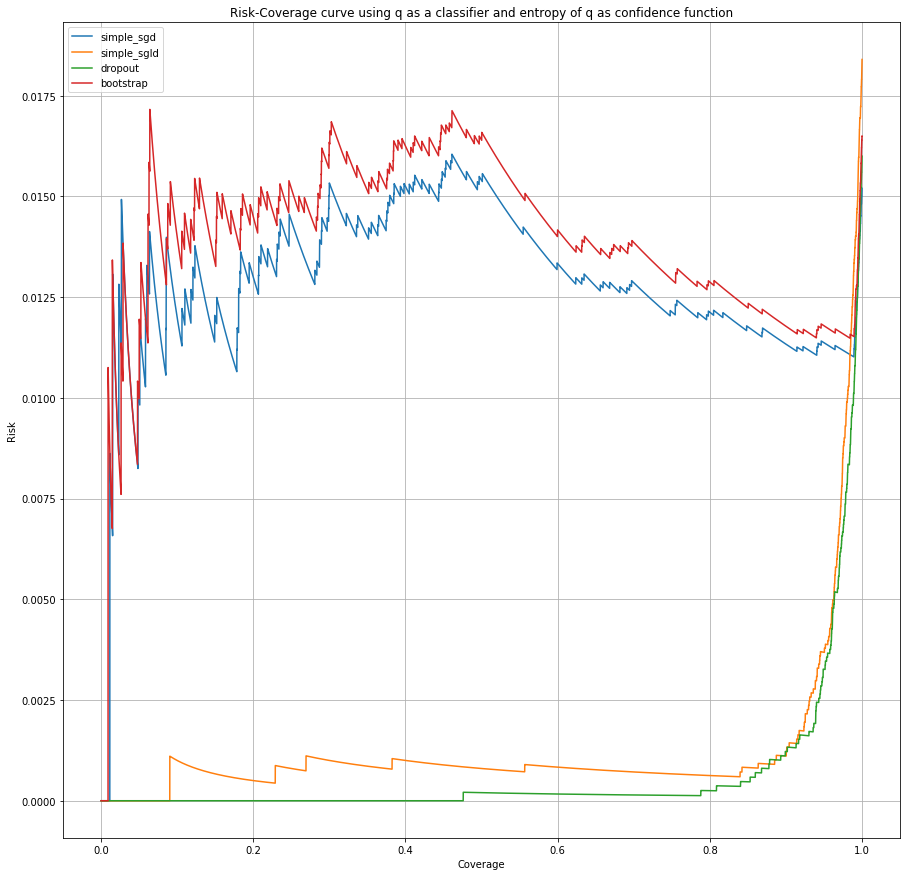

In [20]:
rm.plot_risk_coverage()

In [25]:
rm.compute_table()
table = rm.table
table

,accuracy,neg loglikelihood,brier score,expected calibration error,maximum calibration error,AURC std max p,AURC max p,AURC entropy q
sgd,0.9848,0.070014,0.002585,0.020290,0.240725,0.000537,0.000578,0.012870
sgld,0.9816,0.071866,0.002817,0.012449,0.299134,0.000681,0.000727,0.001204
dropout,0.9840,0.054757,0.002480,0.002517,0.263008,0.000571,0.000503,0.000579
bootstrap,0.9835,0.094402,0.002820,0.045222,0.615407,0.000565,0.000772,0.013905
onepoint,0.9775,0.146420,0.003867,0.059255,0.296174,NaN,0.001410,NaN


# Imagenet s10

In [6]:
dataset = 'imagenet-first-1000'
y = np.load('saved_models/{}/y.npy'.format(dataset))
path_sgd = 'D:/outputs/last_layer/imagenet-first-1000_sgdsgld_lr-0.01_bs-512_s-10'
path = 'D:/outputs/last_layer/imagenet-first-1000_dropout_ep-10_lr-0.01_bs-512_s-10_pdrop-0.1'
with open(os.path.join(path_sgd, 'metrics_dic.pkl'), 'rb') as f:
  sgd = pickle.load(f)
with open(os.path.join(path, 'metrics_dic.pkl'), 'rb') as f:
  dropout = pickle.load(f)

In [ ]:
# import numpy as np
# import os
# import pickle

# import utils.metrics as metrics

# dataset = 'imagenet-first-1000'
# y = np.load('saved_models/{}/y.npy'.format(dataset))
# path_sgd = 'outputs/last_layer/imagenet-first-1000_sgdsgld_lr-0.01_bs-512_s-10'
# with open(os.path.join(path_sgd, 'dic_sgd.pkl'), 'rb') as f:
#   sgd = pickle.load(f)
  
# y_true = np.argmax(y, axis=1)
# p_mean = sgd['p_mean']
# p_std = sgd['p_std']
# y_pred = np.argmax(p_mean, axis=1)
# conf_2 = - p_std[np.arange(p_std.shape[0]), y_pred]
# conf_1 = np.max(p_mean, axis=1)
  
# res = metrics.sec_classification_comb(y_true, y_pred, conf_1, conf_2)

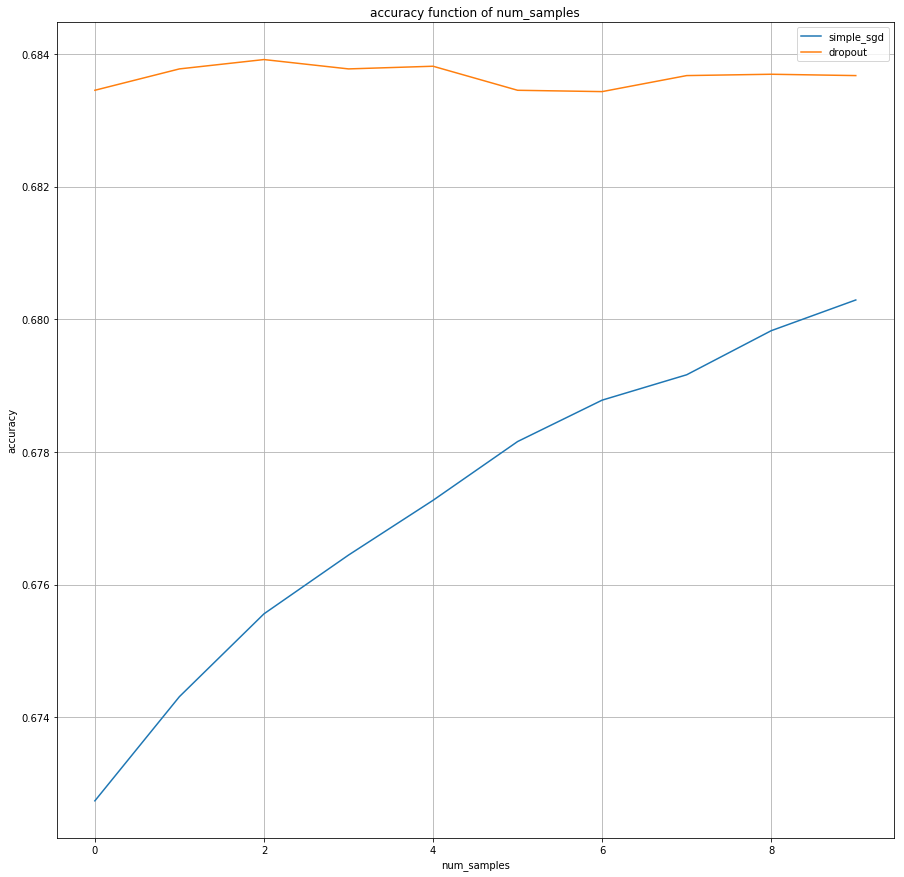

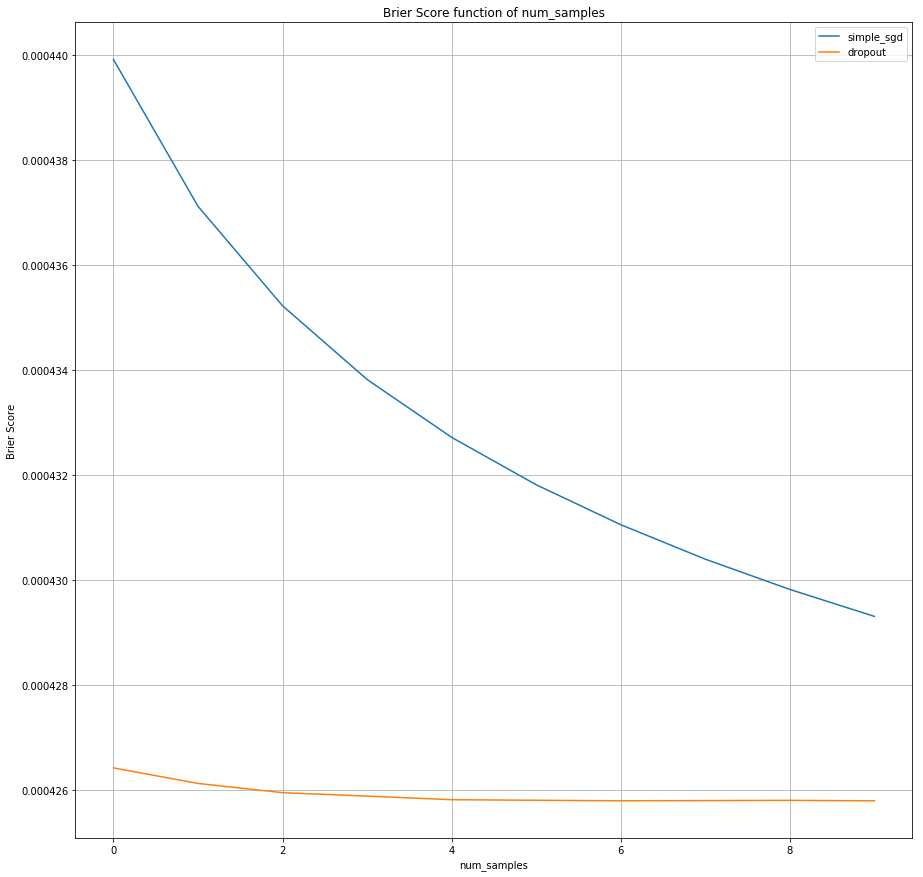

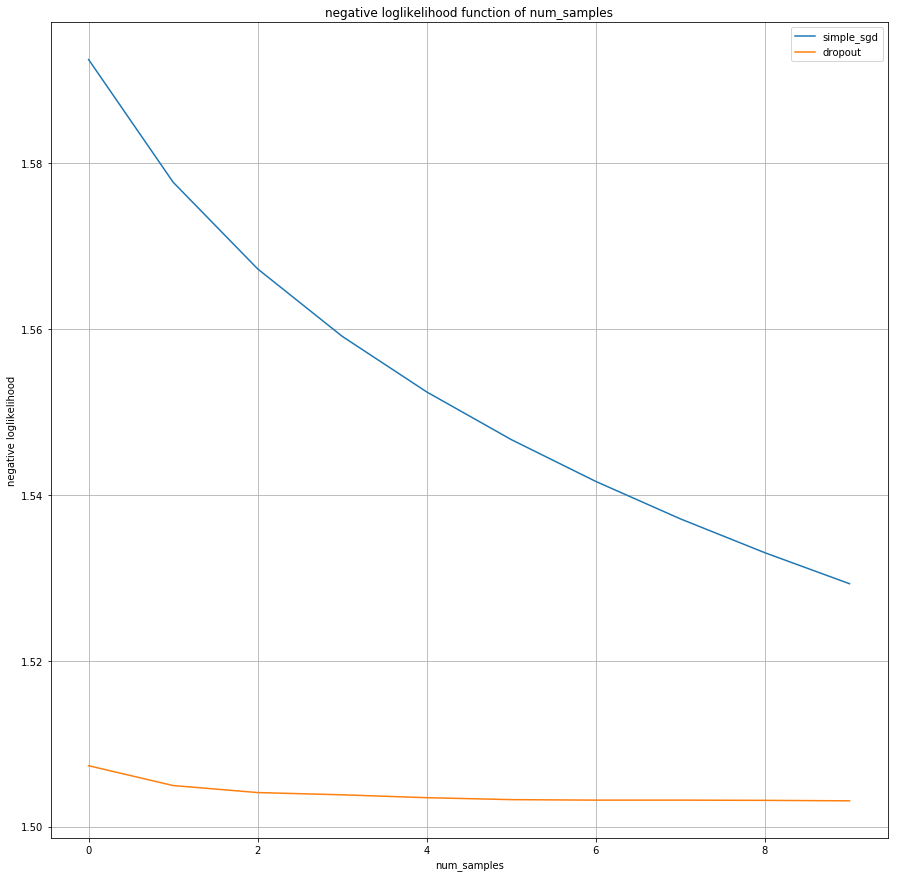

In [7]:
for metric in ['acc', 'bs', 'neglog']:
  plt.figure(figsize=(15,15))
  plt.plot(sgd[metric], label='simple_sgd')
  plt.plot(dropout[metric], label='dropout')
  plt.xlabel('num_samples')
  plt.ylabel(dic_metrics[metric])
  plt.title(dic_metrics[metric] + ' function of num_samples')
  plt.grid(True)
  plt.legend()
  plt.show()

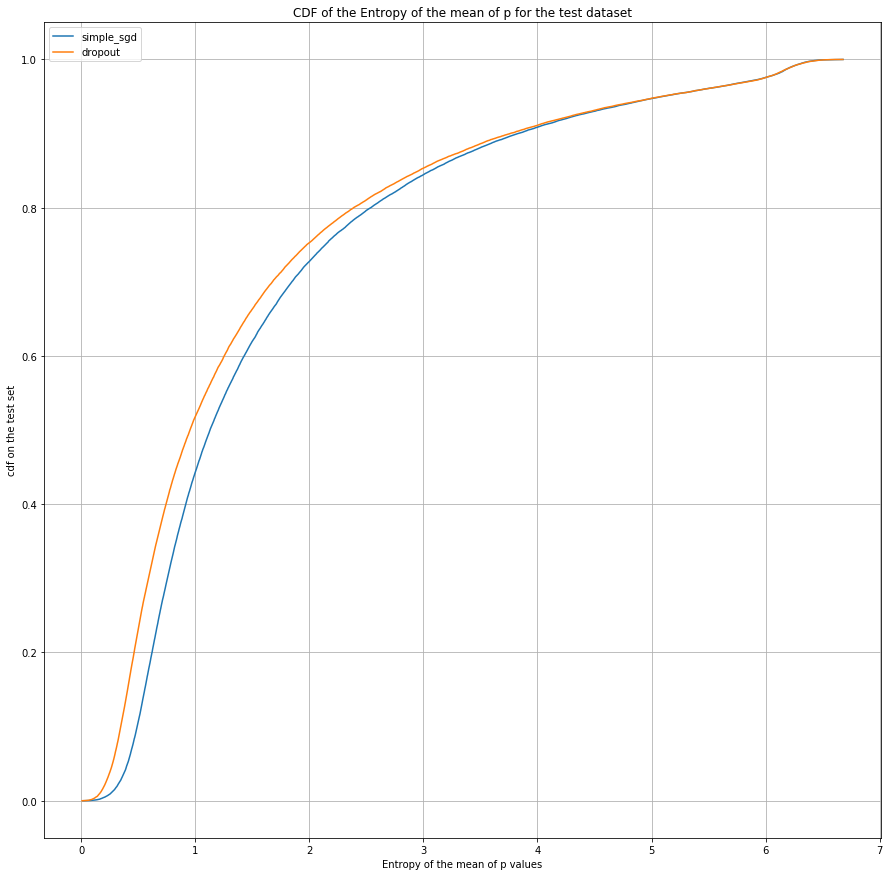

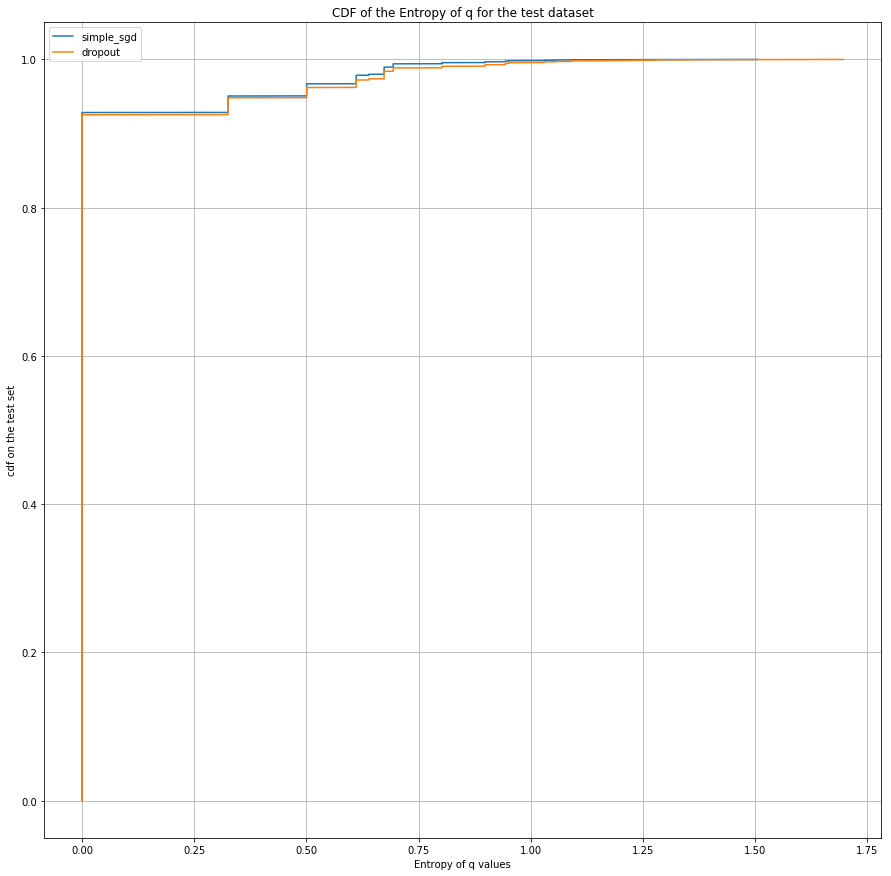

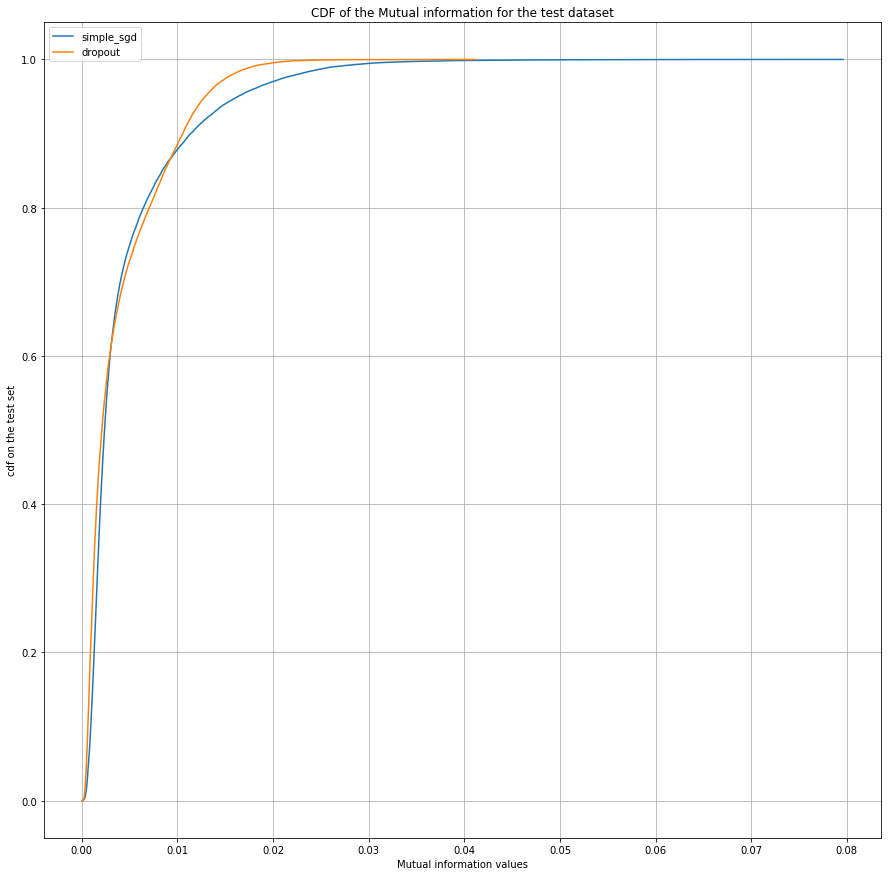

In [6]:
for metric in ['ent', 'ent_q', 'mi']:
  plt.figure(figsize=(15,15))
  n_test = len(sgd[metric]) 
  cdf_tab = np.arange(1, n_test+1, dtype=np.float) / n_test
  plt.plot(np.sort(sgd[metric]), cdf_tab, label='simple_sgd')
  plt.plot(np.sort(dropout[metric]), cdf_tab, label='dropout')
  plt.xlabel(dic_metrics[metric] + ' values')
  plt.ylabel('cdf on the test set')
  plt.title('CDF of the {} for the test dataset'.format(dic_metrics[metric]))   
  plt.grid(True)
  plt.legend()
  plt.show()

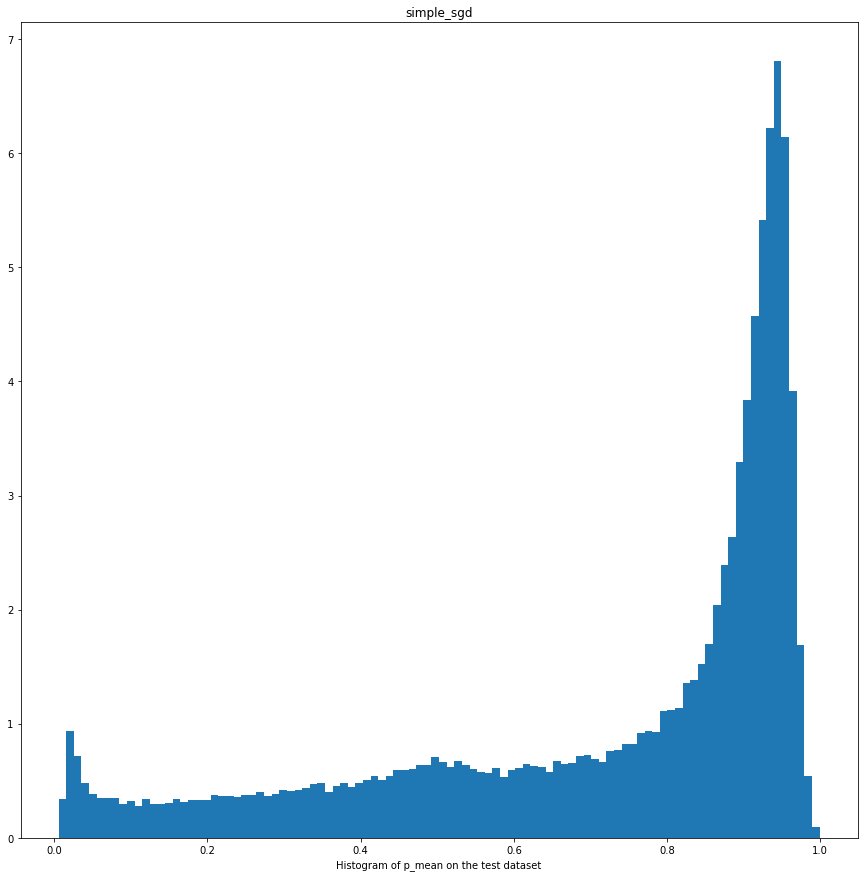

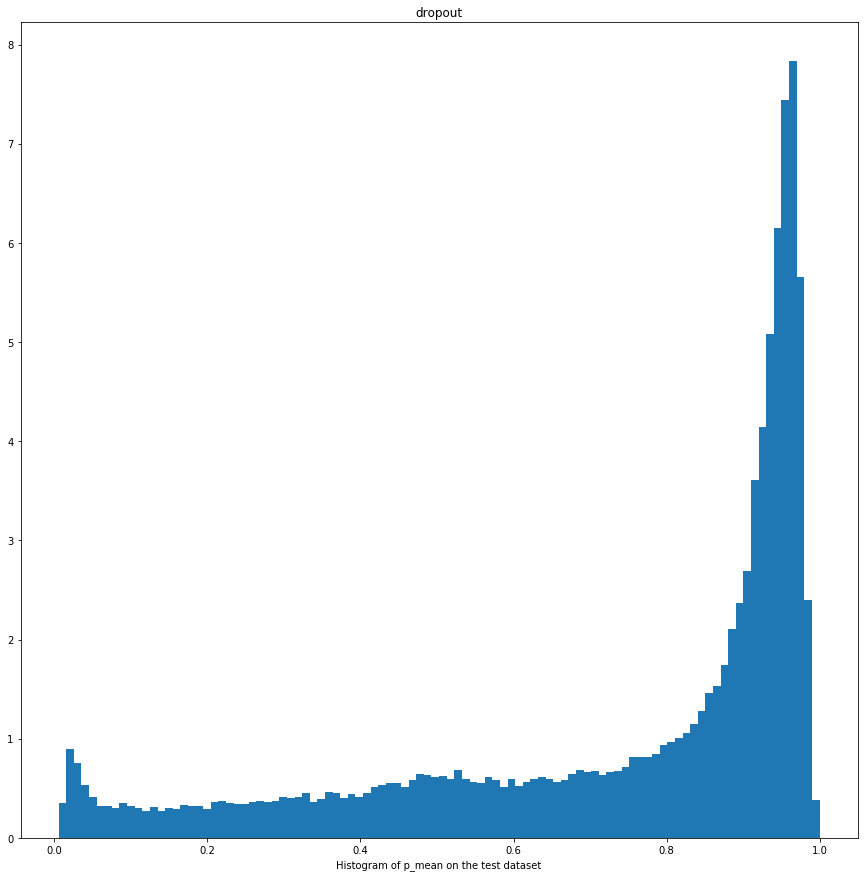

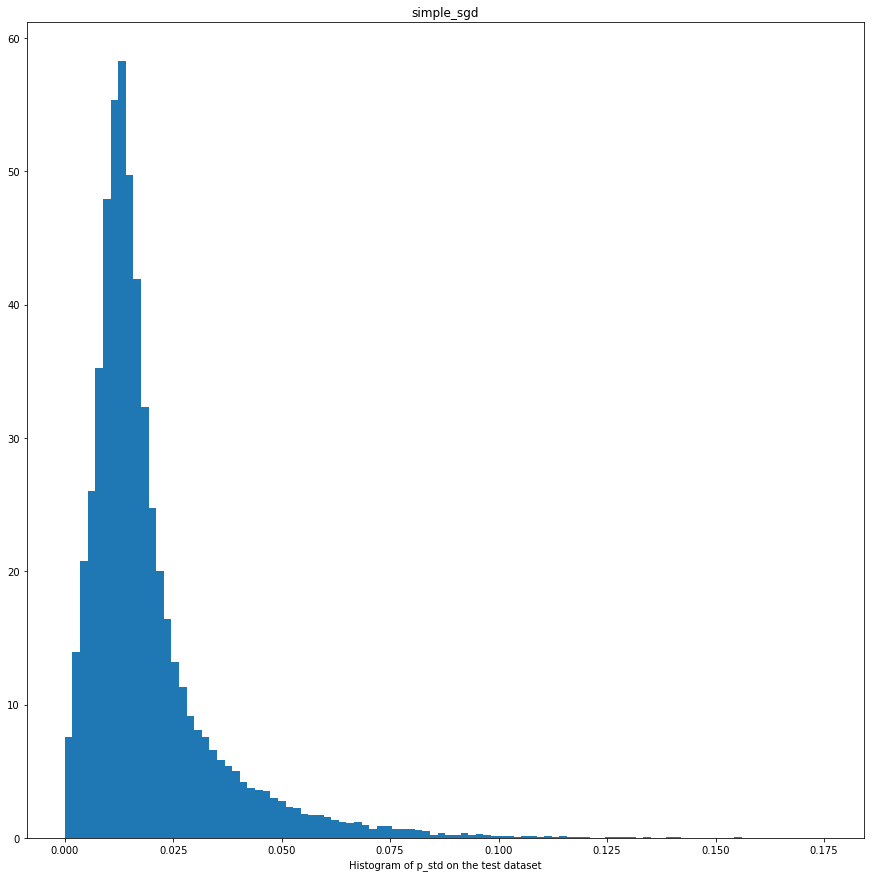

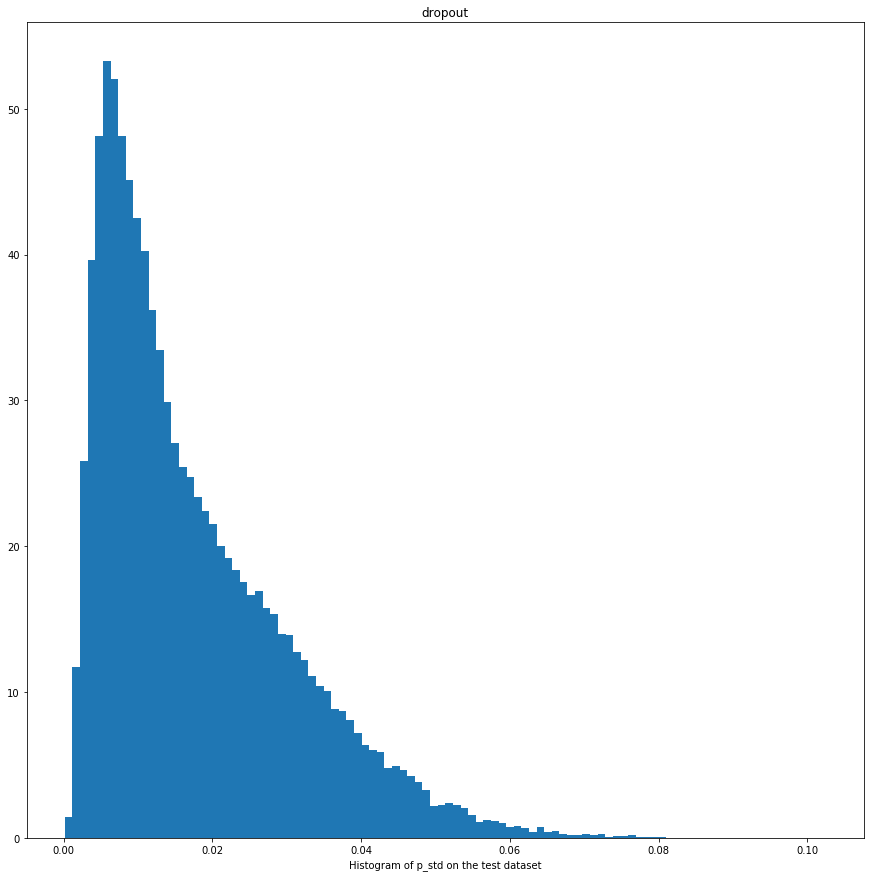

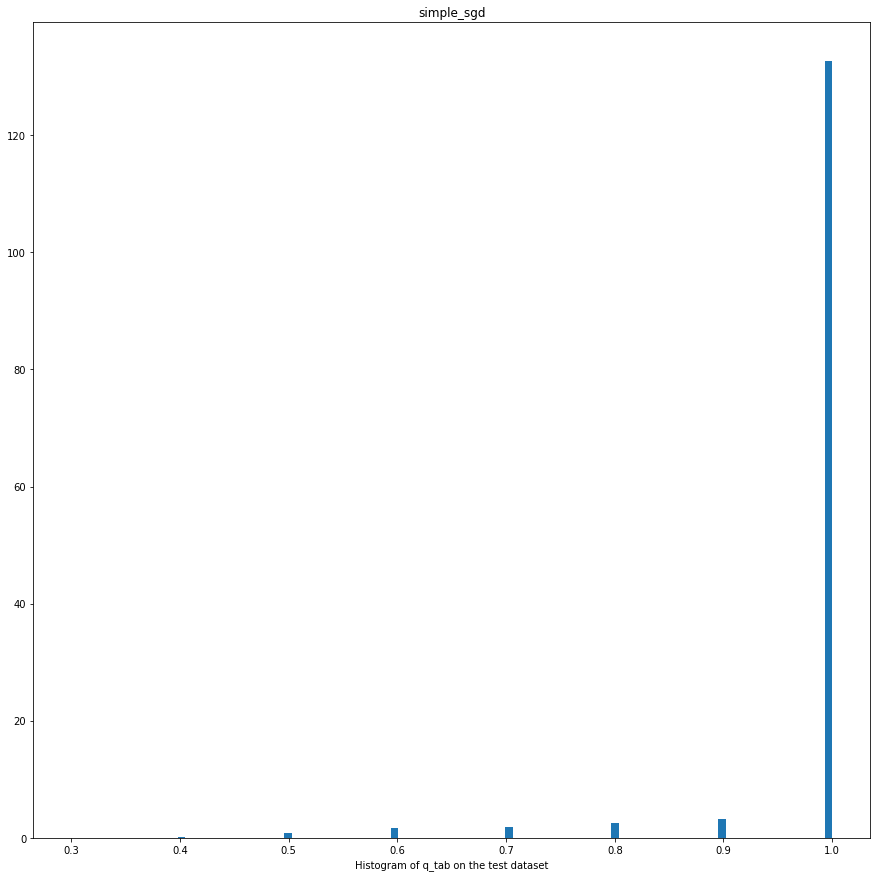

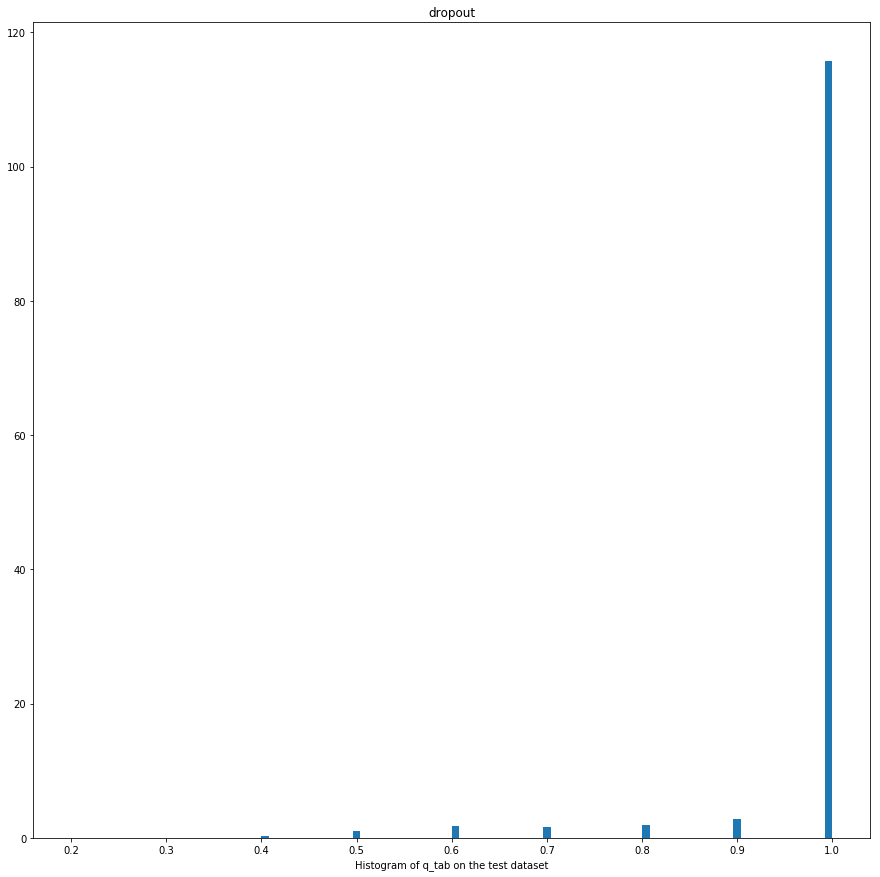

In [7]:
for metric in ['p_mean', 'p_std', 'q_tab']:
  if metric == 'p_std':
    n = sgd[metric].shape[0]
    h1 = sgd[metric][np.arange(n), 
                                 np.argmax(sgd['p_mean'], axis=1)]
  else:
    h1 = np.max(sgd[metric], axis=1)

  plt.figure(figsize=(15,15))
  plt.hist(h1, bins=100, density=True)
  plt.xlabel('Histogram of {} on the test dataset'.format(metric))
  plt.title('simple_sgd')
  plt.show()
  if metric == 'p_std':
    n = dropout[metric].shape[0]
    h1 = dropout[metric][np.arange(n), 
                                 np.argmax(dropout['p_mean'], axis=1)]
  else:
    h1 = np.max(dropout[metric], axis=1)

  plt.figure(figsize=(15,15))
  plt.hist(h1, bins=100, density=True)
  plt.xlabel('Histogram of {} on the test dataset'.format(metric))
  plt.title('dropout')
  plt.show()

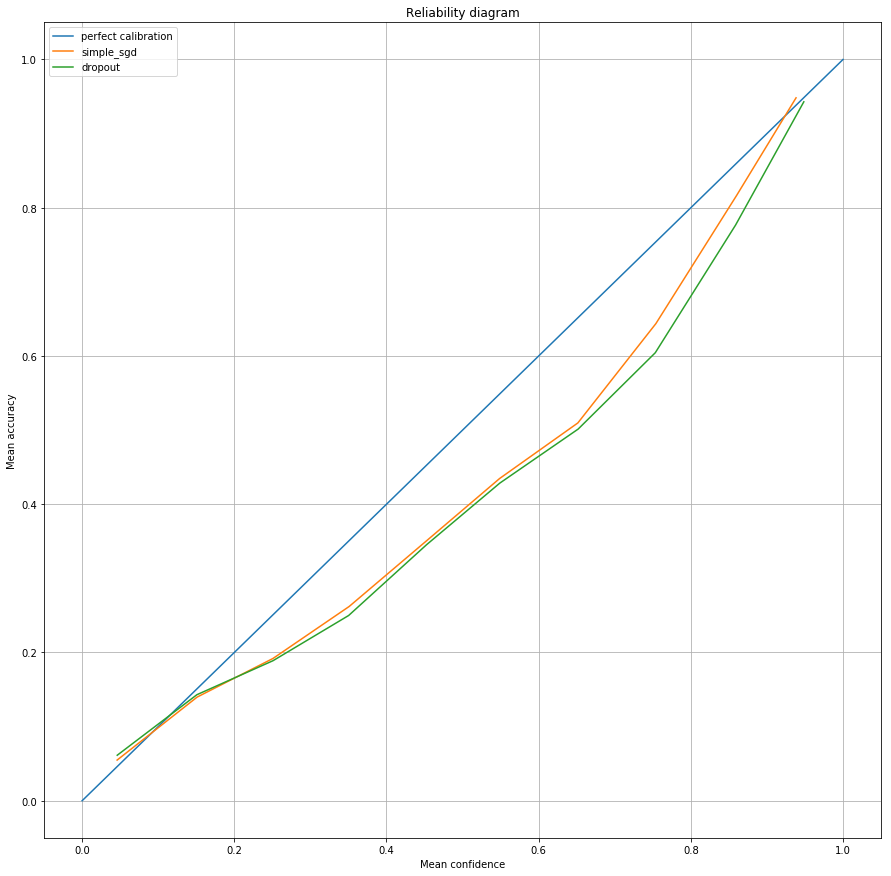

In [8]:
plt.figure(figsize=(15,15))
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), label='perfect calibration')
plt.plot(sgd['cal']['reliability_diag'][0], 
         sgd['cal']['reliability_diag'][1], 
         label='simple_sgd')
plt.plot(dropout['cal']['reliability_diag'][0], 
         dropout['cal']['reliability_diag'][1], 
         label='dropout')
plt.grid(True)
plt.xlabel('Mean confidence')
plt.ylabel('Mean accuracy')
plt.title('Reliability diagram')
plt.legend()
plt.show()

In [11]:
y.shape

(49664, 1000)

In [12]:
p_mean = sgd['p_mean']
p_std = sgd['p_std']
y_pred = np.argmax(p_mean, axis=1)
y_true = np.argmax(y, axis=1)
conf = np.max(p_mean, axis=1)

In [13]:
n = len(y_true)
ind = np.argsort(conf)
y_true, y_pred, conf = y_true[ind][::-1], y_pred[ind][::-1], conf[ind][::-1]
risk_cov = np.divide(np.cumsum(y_true != y_pred).astype(np.float),
                     np.arange(1, n+1))
nrisk = np.sum(y_true != y_pred)
aurc = np.mean(risk_cov)
opt_aurc = (1./n) * np.sum(np.divide(np.arange(1, nrisk + 1).astype(np.float),
                                     n - nrisk + np.arange(1, nrisk + 1)))
eaurc = aurc - opt_aurc
dic = {'conf': conf,
       'risk_cov': risk_cov,
       'aurc': aurc,
       'eaurc': eaurc
      }

In [21]:
print(conf[:5000])
print(risk_cov[:5000])
print(ind)
ind_conf = ind[-5000:]
np.save('ind_conf.npy', ind_conf)

[0.9990541  0.99850684 0.9981818  ... 0.9527639  0.95276153 0.95275813]
[0.         0.         0.         ... 0.03501401 0.035007   0.035     ]
[45571 47525 43296 ... 37179 30123  5736]


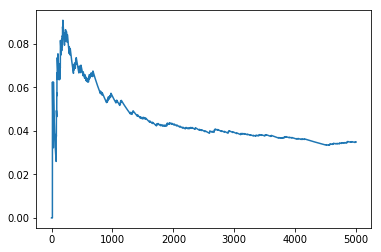

In [18]:
plt.plot(risk_cov[:5000])

In [24]:
sec = np.load('sec.npy')
sec.shape
np.max(sec, axis=1)

array([[0.9389421 , 0.95206666, 0.959701  , ..., 0.97606236, 0.977783  ,
        0.9792614 ],
       [0.9401591 , 0.95414215, 0.96243936, ..., 0.98160905, 0.9835751 ,
        0.9852165 ],
       [0.9385799 , 0.95348763, 0.96168673, ..., 0.9774022 , 0.9789757 ,
        0.9803341 ],
       ...,
       [0.9470945 , 0.9521998 , 0.9563147 , ..., 0.9695654 , 0.97129977,
        0.97283465],
       [0.9295522 , 0.94190377, 0.9486592 , ..., 0.96123827, 0.9624738 ,
        0.9635465 ],
       [0.91216093, 0.93089277, 0.9428827 , ..., 0.9690833 , 0.97171336,
        0.9739386 ]], dtype=float32)

In [12]:
sgd.keys()
p_max_min = sgd['p_max_min']
p_std = sgd['p_std']
q_tab = sgd['q_tab']
p_mean = sgd['p_mean']
res_aurc = metrics.aurc(y, p_mean, p_std, q_tab, p_max_min)
risk_cov_maxmin = res_aurc['risk_cov_maxmin']

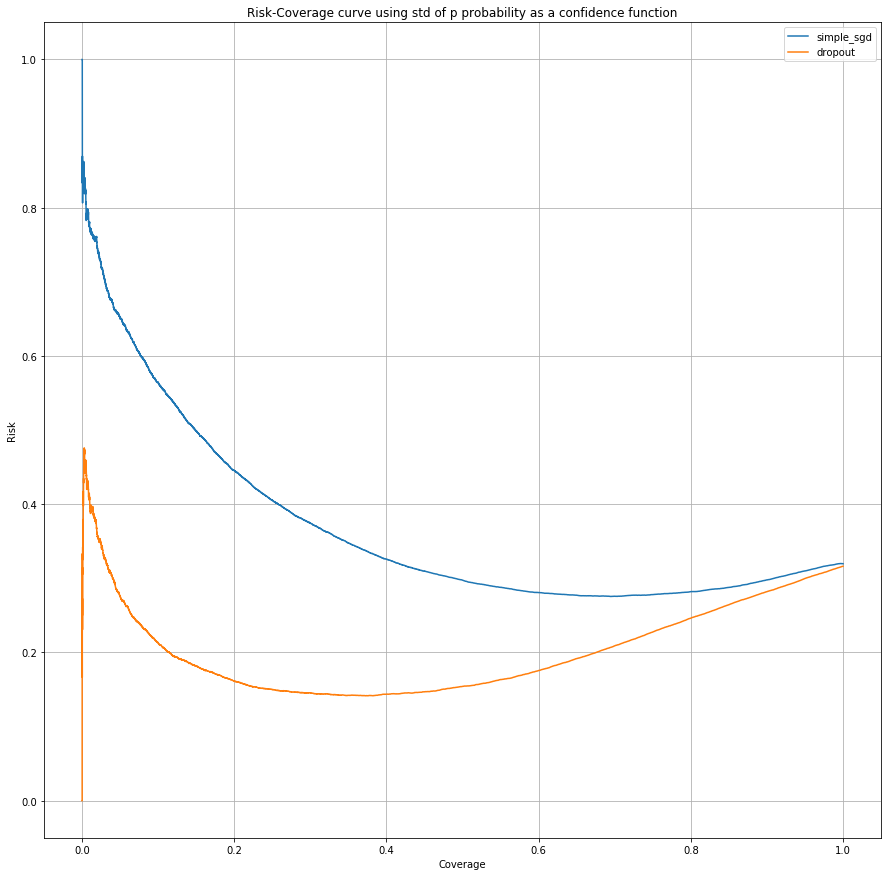

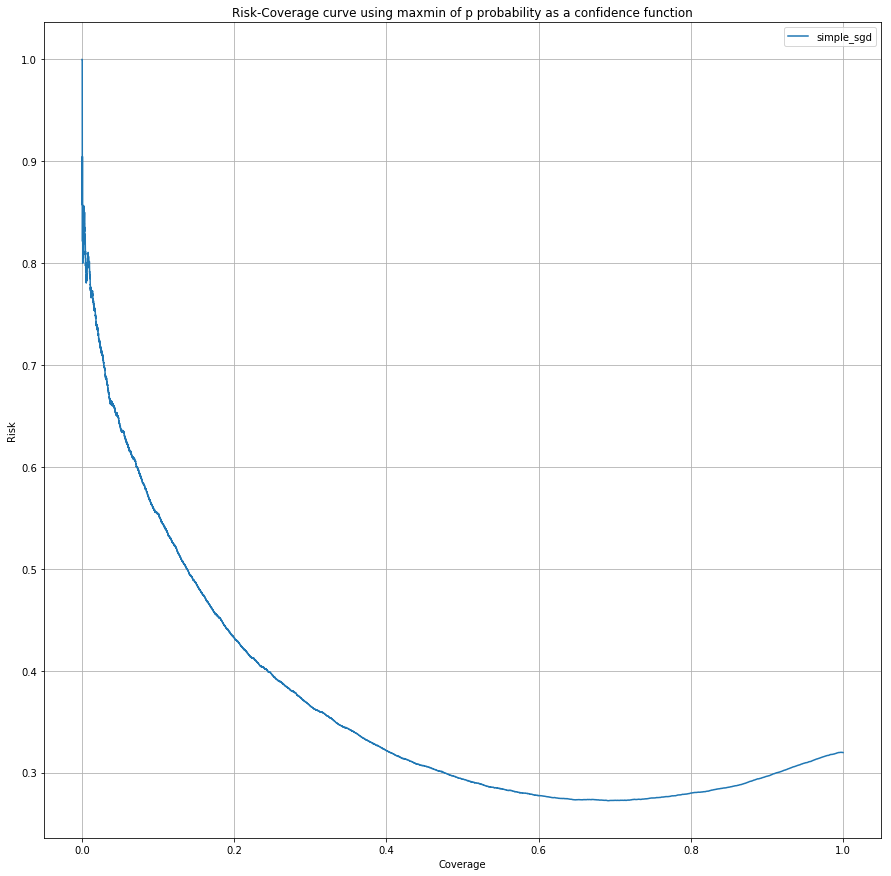

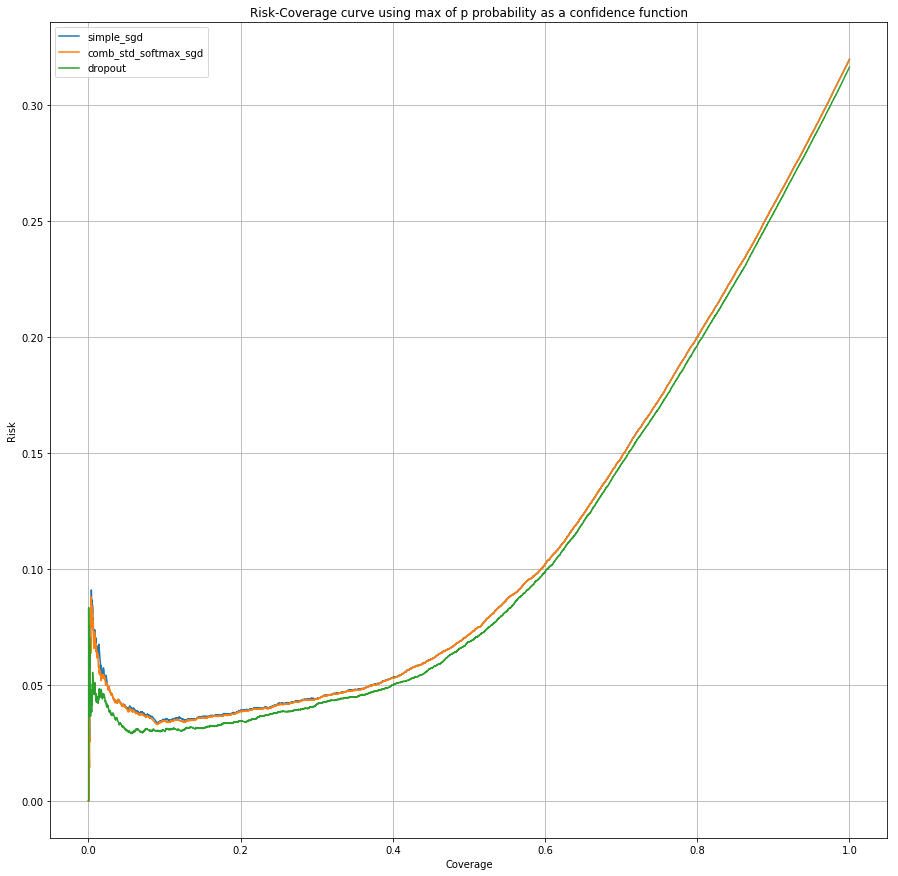

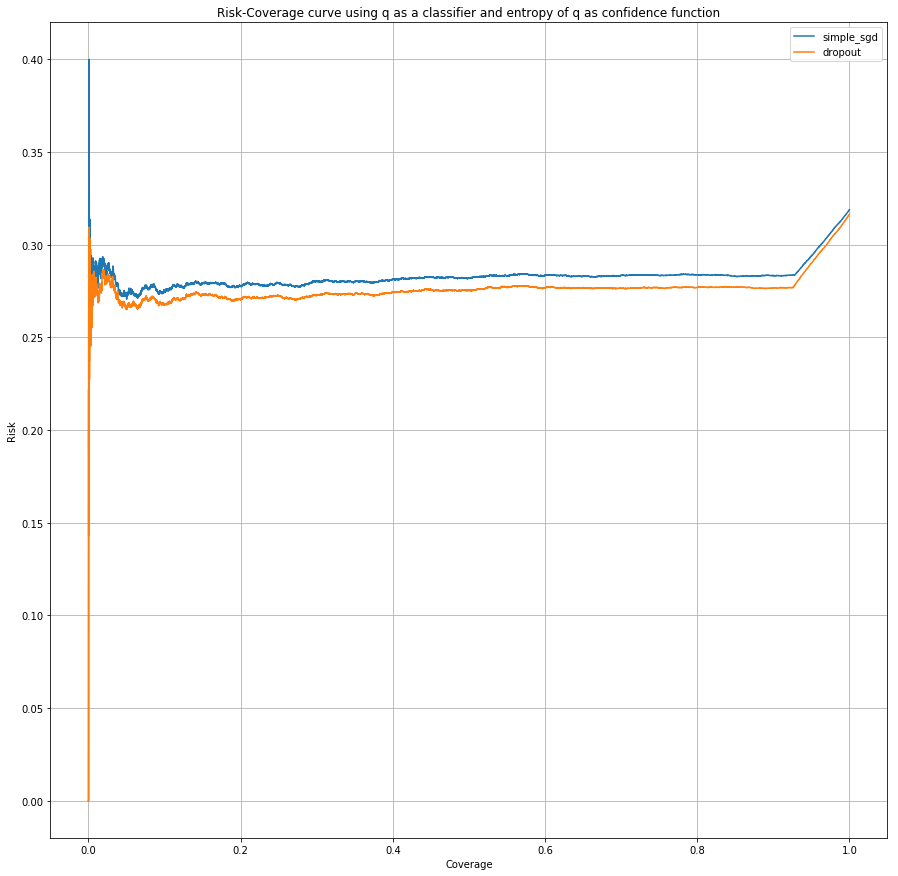

In [15]:
plt.figure(figsize=(15,15))
n = len(sgd['risk_cov_std']['risk_cov'])
x = np.arange(1./n, 1 + 1./n, 1./n)
plt.plot(x, sgd['risk_cov_std']['risk_cov'], label='simple_sgd')
plt.plot(x, dropout['risk_cov_std']['risk_cov'], label='dropout')
plt.grid(True)
plt.xlabel('Coverage')
plt.ylabel('Risk')
plt.title('Risk-Coverage curve using std of p probability as a confidence function')
plt.legend()
plt.show()    

plt.figure(figsize=(15,15))
n = len(risk_cov_maxmin['risk_cov'])
x = np.arange(1./n, 1 + 1./n, 1./n)
plt.plot(x, risk_cov_maxmin['risk_cov'], label='simple_sgd')
plt.grid(True)
plt.xlabel('Coverage')
plt.ylabel('Risk')
plt.title('Risk-Coverage curve using maxmin of p probability as a confidence function')
plt.legend()
plt.show() 

results = np.load('D:/outputs/last_layer/imagenet-first-1000_sgdsgld_lr-0.01_bs-512_s-10/'
                  'temp/results.npy')

plt.figure(figsize=(15,15))
plt.plot(x, sgd['risk_cov_softmax']['risk_cov'], label='simple_sgd')
plt.plot(x, results[0, :], label='comb_std_softmax_sgd')
plt.plot(x, dropout['risk_cov_softmax']['risk_cov'], label='dropout')
plt.grid(True)
plt.xlabel('Coverage')
plt.ylabel('Risk')
plt.title('Risk-Coverage curve using max of p probability as a confidence function')
plt.legend()
plt.show()

plt.figure(figsize=(15,15))
plt.plot(x, sgd['risk_cov_q']['risk_cov'], label='simple_sgd')
plt.plot(x, dropout['risk_cov_q']['risk_cov'], label='dropout')
plt.grid(True)
plt.xlabel('Coverage')
plt.ylabel('Risk')
plt.title('Risk-Coverage curve using q as a classifier and entropy of q as confidence function')
plt.legend()
plt.show()

# Imagenet s100

In [13]:
dataset = 'imagenet-first-1000'
y = np.load('saved_models/{}/y.npy'.format(dataset))
path_sgd = 'D:/outputs/last_layer/imagenet-first-1000_sgdsgld_lr-0.01_bs-512_s-100'
with open(os.path.join(path_sgd, 'dic_sgd.pkl'), 'rb') as f:
  sgd = pickle.load(f)

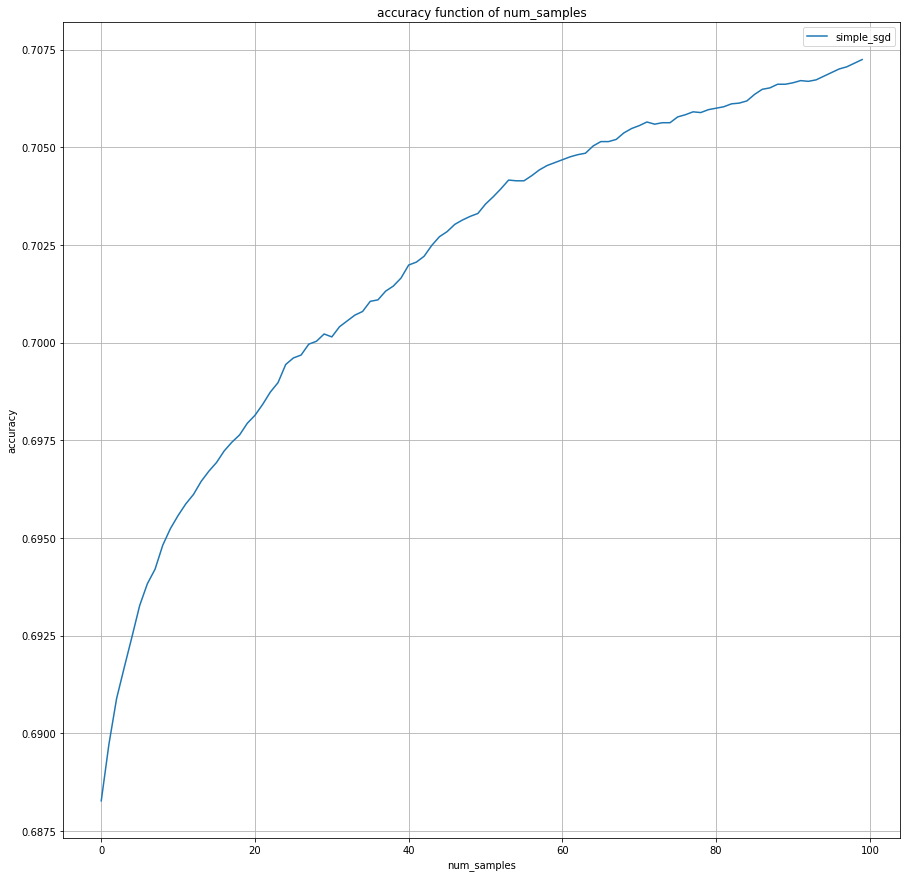

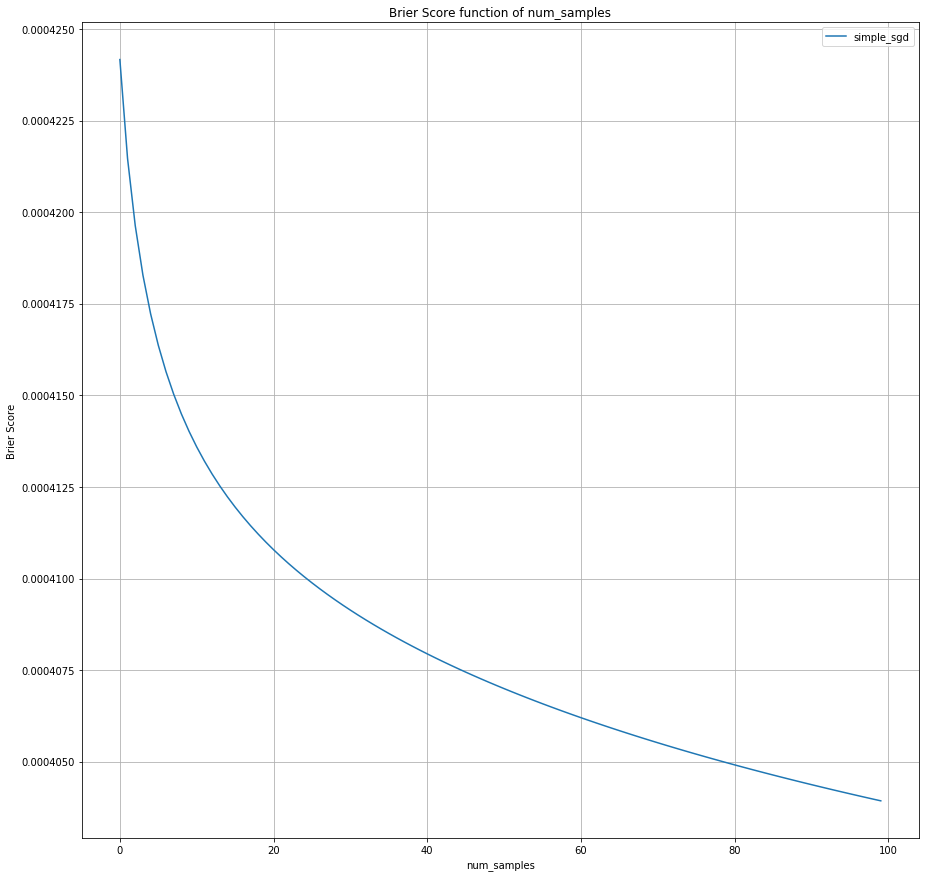

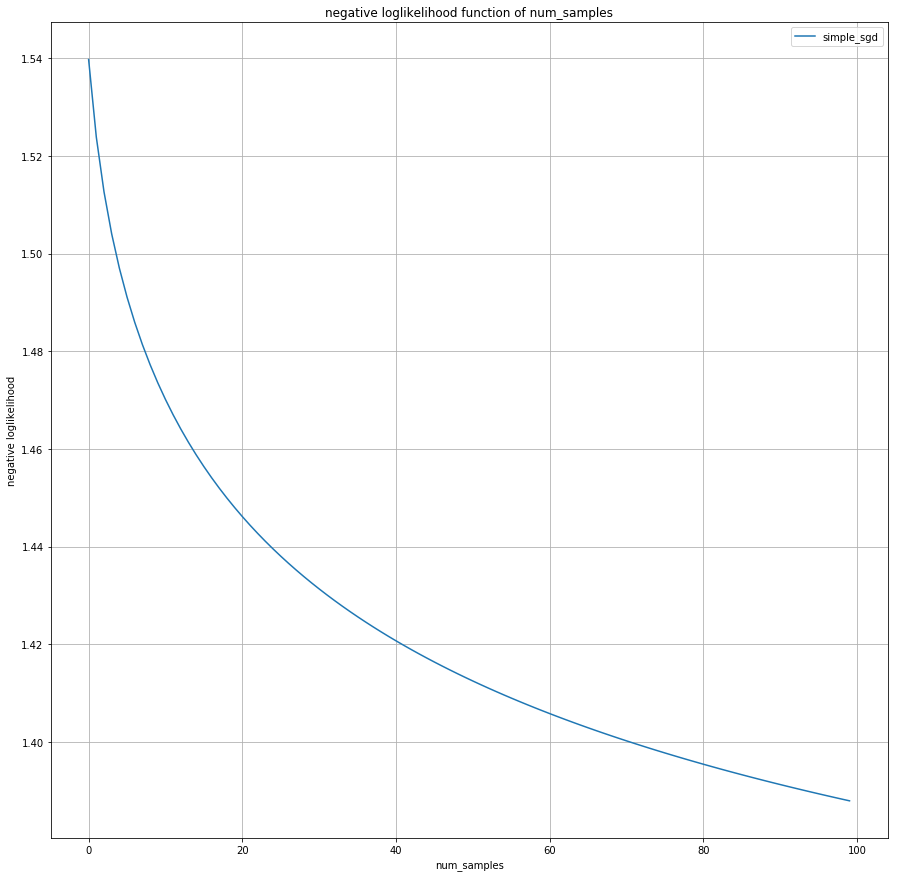

In [14]:
for metric in ['acc', 'bs', 'neglog']:
  plt.figure(figsize=(15,15))
  plt.plot(sgd[metric], label='simple_sgd')
  plt.xlabel('num_samples')
  plt.ylabel(dic_metrics[metric])
  plt.title(dic_metrics[metric] + ' function of num_samples')
  plt.grid(True)
  plt.legend()
  plt.show()

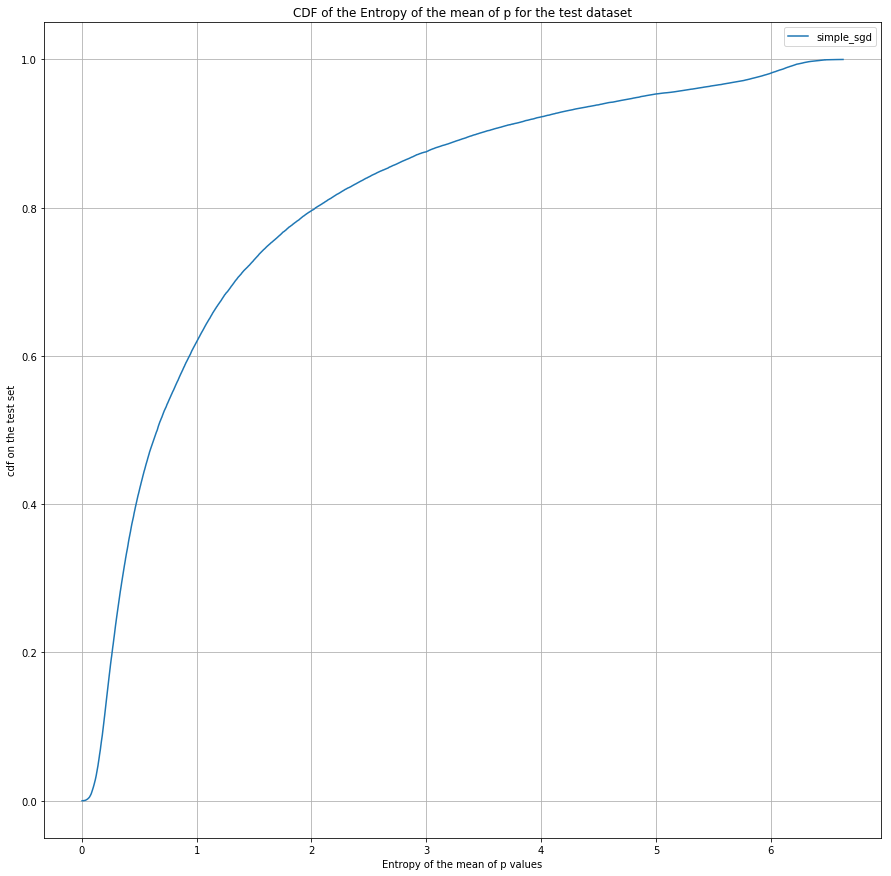

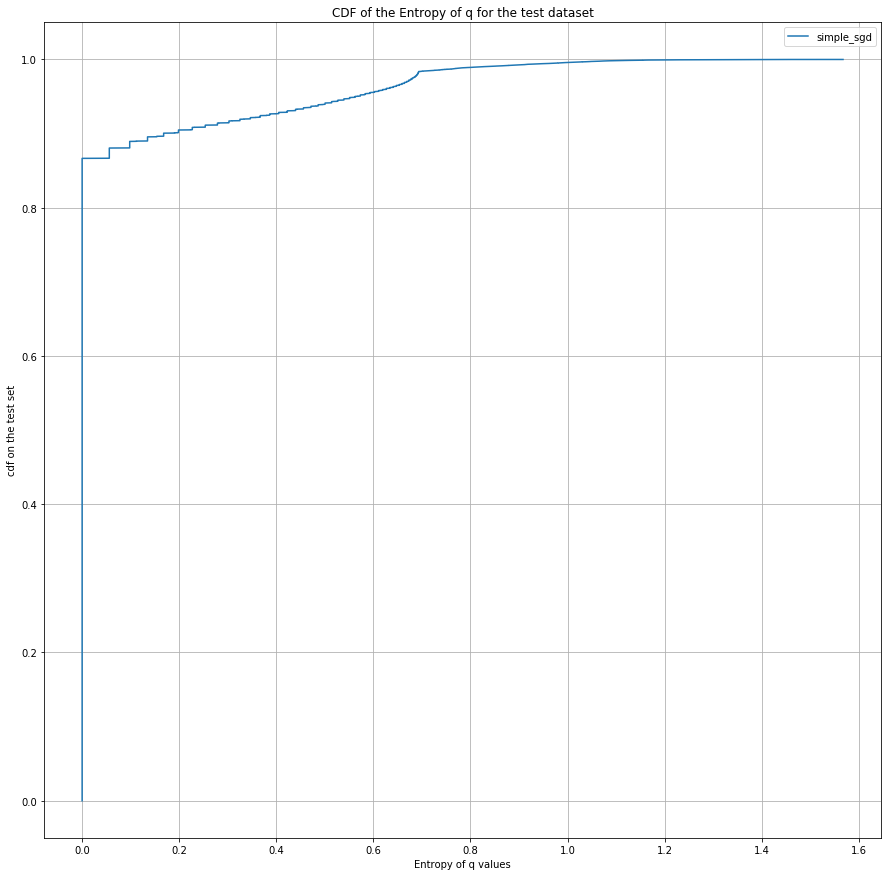

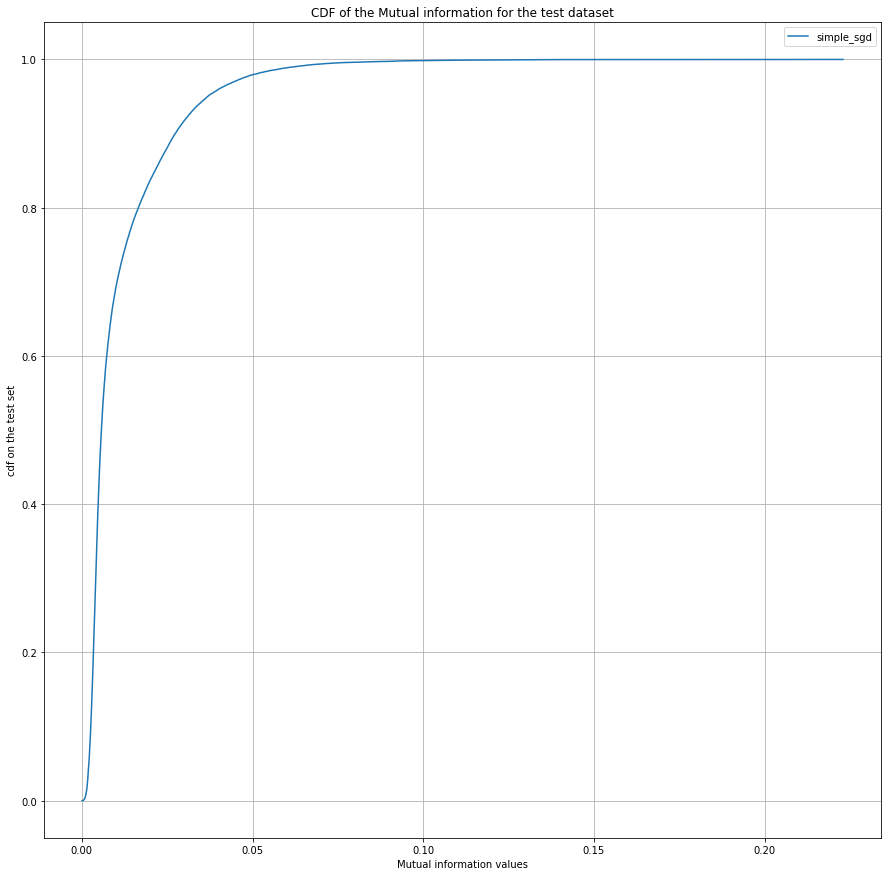

In [15]:
for metric in ['ent', 'ent_q', 'mi']:
  plt.figure(figsize=(15,15))
  n_test = len(sgd[metric]) 
  cdf_tab = np.arange(1, n_test+1, dtype=np.float) / n_test
  plt.plot(np.sort(sgd[metric]), cdf_tab, label='simple_sgd')
  plt.xlabel(dic_metrics[metric] + ' values')
  plt.ylabel('cdf on the test set')
  plt.title('CDF of the {} for the test dataset'.format(dic_metrics[metric]))   
  plt.grid(True)
  plt.legend()
  plt.show()

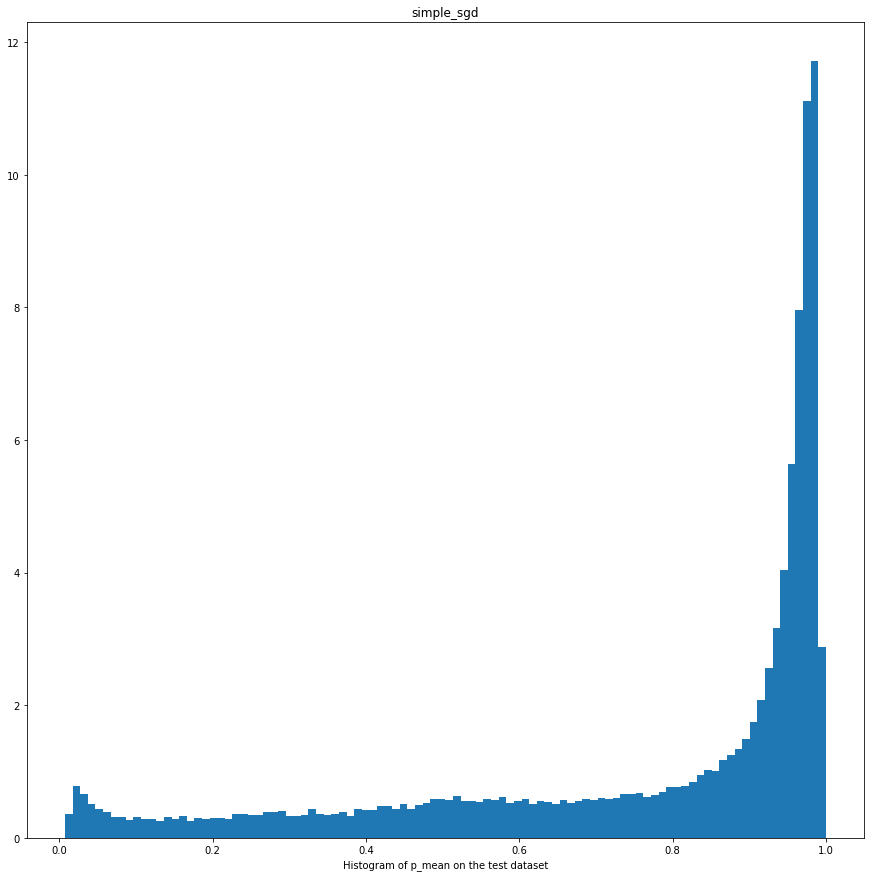

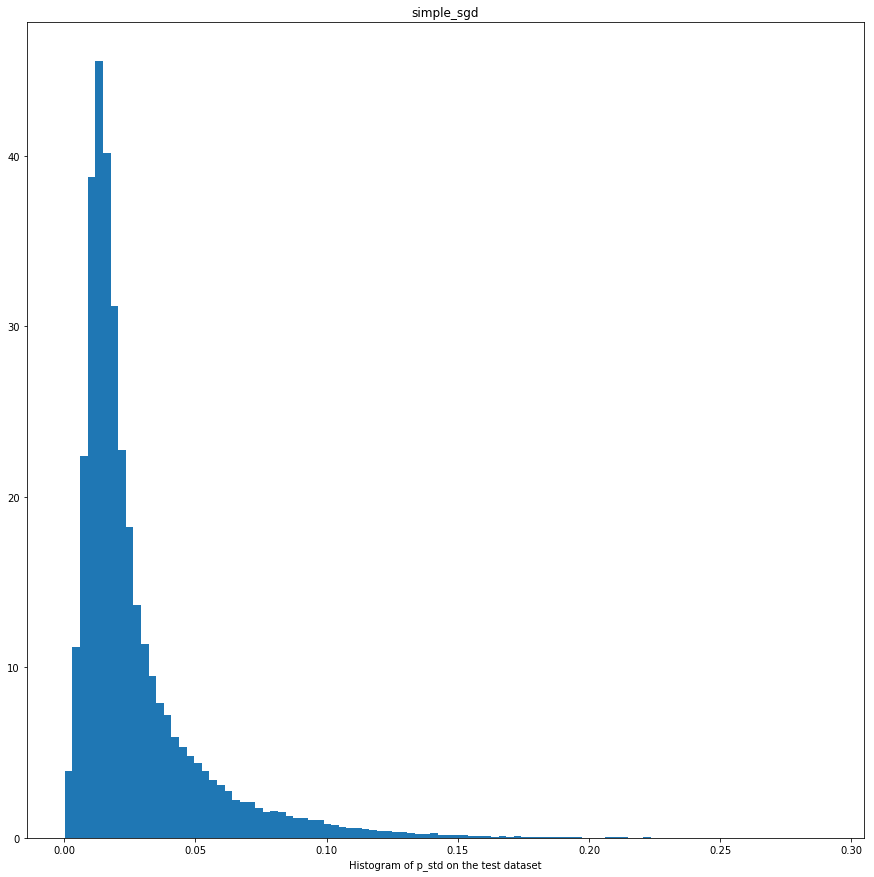

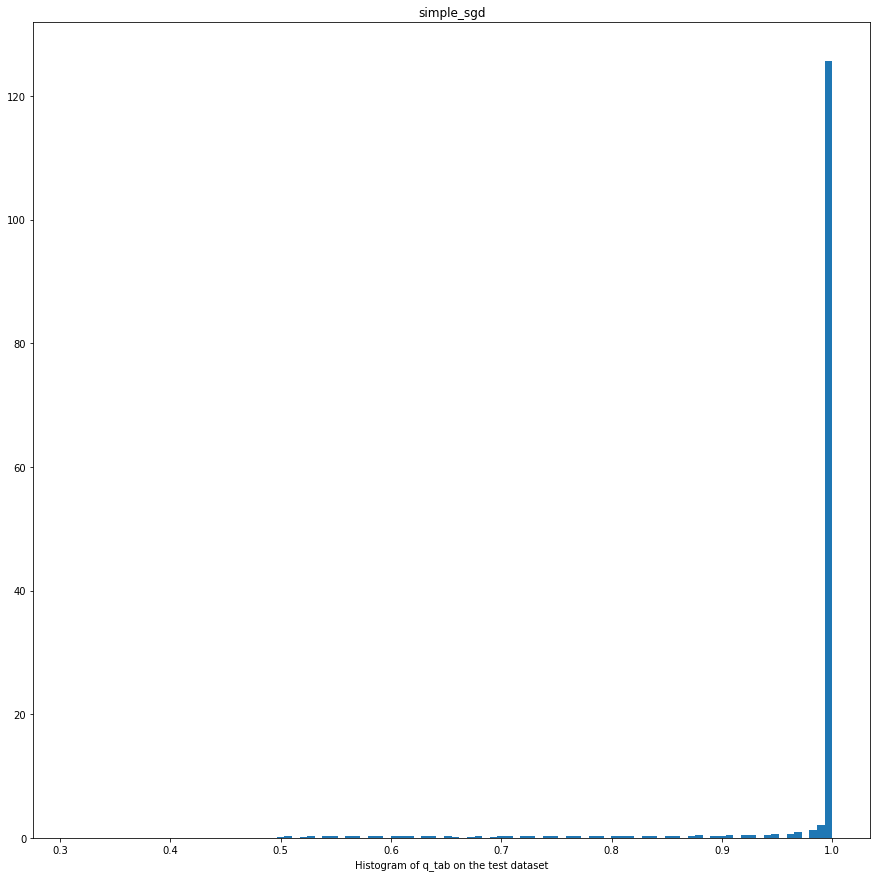

In [16]:
for metric in ['p_mean', 'p_std', 'q_tab']:
  if metric == 'p_std':
    n = sgd[metric].shape[0]
    h1 = sgd[metric][np.arange(n), 
                                 np.argmax(sgd['p_mean'], axis=1)]
  else:
    h1 = np.max(sgd[metric], axis=1)

  plt.figure(figsize=(15,15))
  plt.hist(h1, bins=100, density=True)
  plt.xlabel('Histogram of {} on the test dataset'.format(metric))
  plt.title('simple_sgd')
  plt.show()

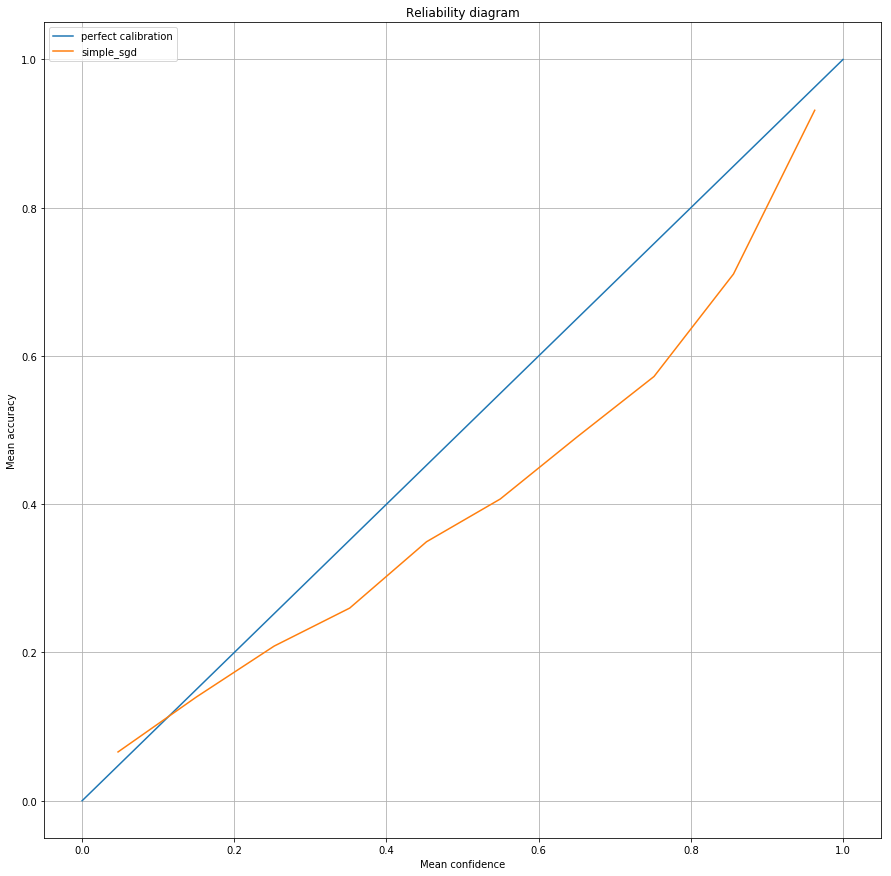

In [17]:
plt.figure(figsize=(15,15))
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), label='perfect calibration')
plt.plot(sgd['cal']['reliability_diag'][0], 
         sgd['cal']['reliability_diag'][1], 
         label='simple_sgd')
plt.grid(True)
plt.xlabel('Mean confidence')
plt.ylabel('Mean accuracy')
plt.title('Reliability diagram')
plt.legend()
plt.show()

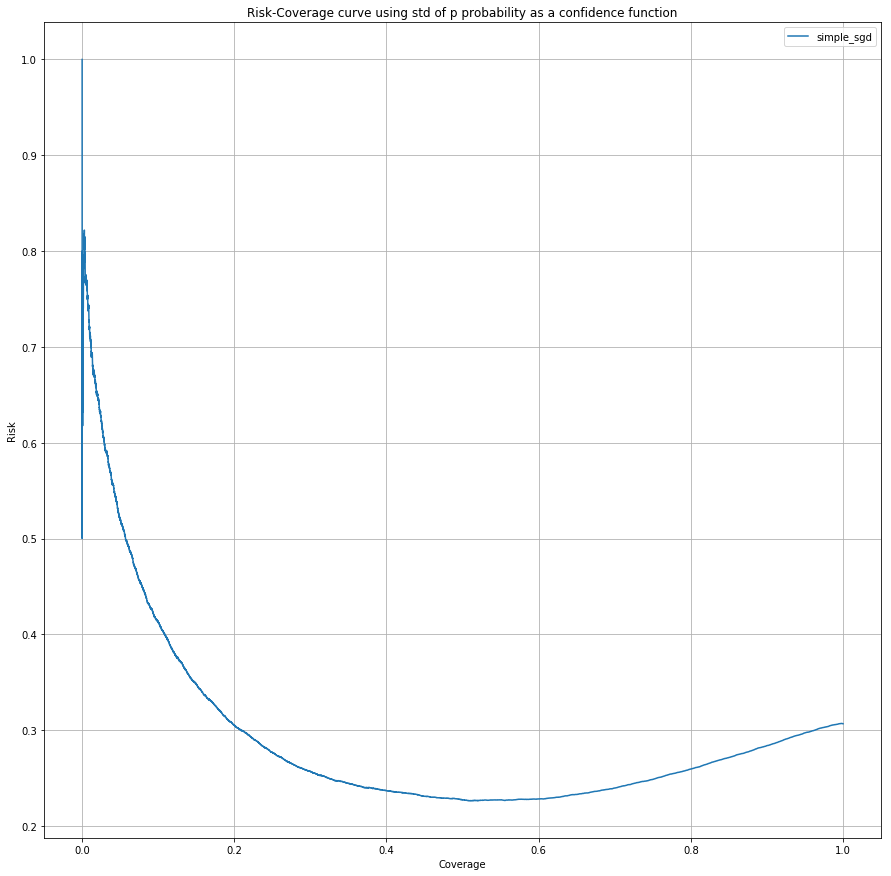

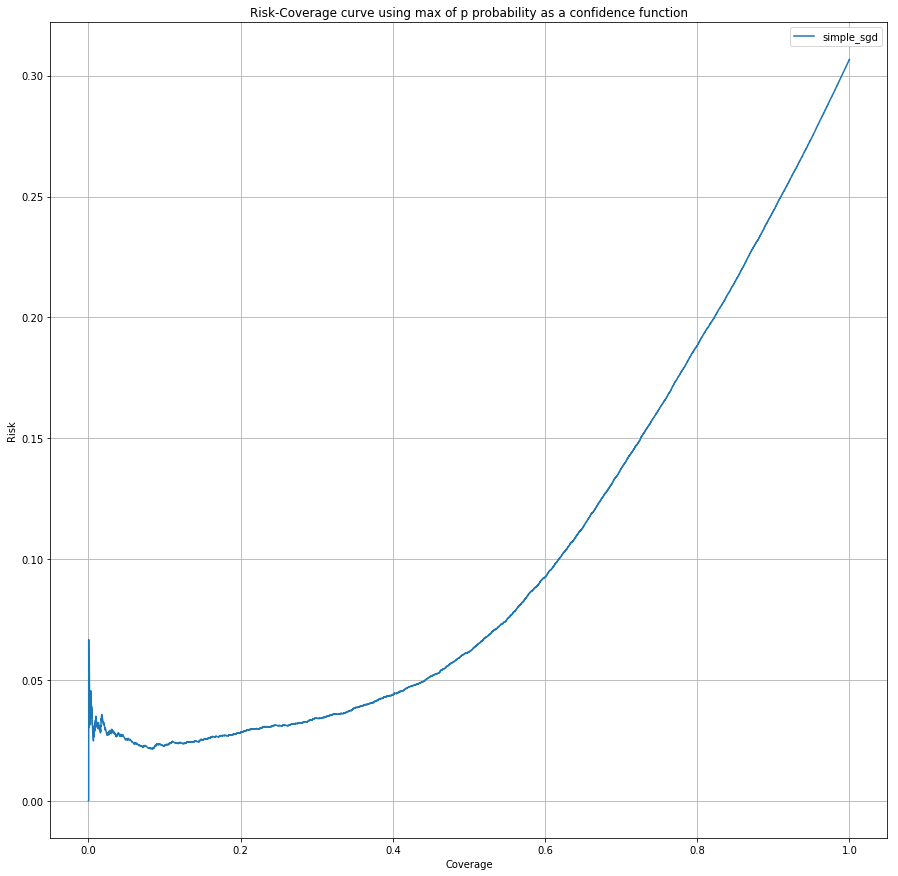

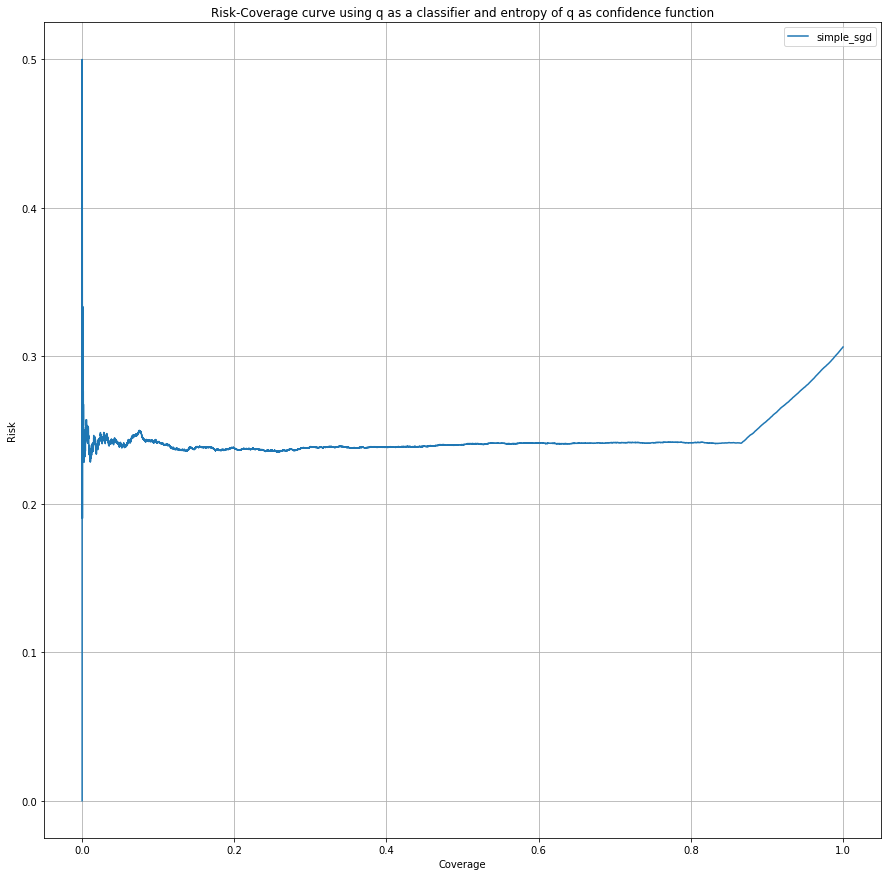

In [18]:
plt.figure(figsize=(15,15))
n = len(sgd['risk_cov_std']['risk_cov'])
x = np.arange(1./n, 1 + 1./n, 1./n)
plt.plot(x, sgd['risk_cov_std']['risk_cov'], label='simple_sgd')
plt.grid(True)
plt.xlabel('Coverage')
plt.ylabel('Risk')
plt.title('Risk-Coverage curve using std of p probability as a confidence function')
plt.legend()
plt.show()    

plt.figure(figsize=(15,15))
plt.plot(x, sgd['risk_cov_softmax']['risk_cov'], label='simple_sgd')
plt.grid(True)
plt.xlabel('Coverage')
plt.ylabel('Risk')
plt.title('Risk-Coverage curve using max of p probability as a confidence function')
plt.legend()
plt.show()

plt.figure(figsize=(15,15))
plt.plot(x, sgd['risk_cov_q']['risk_cov'], label='simple_sgd')
plt.grid(True)
plt.xlabel('Coverage')
plt.ylabel('Risk')
plt.title('Risk-Coverage curve using q as a classifier and entropy of q as confidence function')
plt.legend()
plt.show()